In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pylab as plt

In [2]:
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy")
from cascade.cascade_driver import CascadeDriver, InteractionModel

In [3]:
import chromo
target = chromo.kinematics.CompositeTarget([("N", 0.78), ("O", 0.22)])
ekin = chromo.kinematics.FixedTarget(1e7, "O16", target)
model = chromo.models.DpmjetIII191
    
int_model0 = InteractionModel(model, ekin, target)

In [114]:
from mceq_utils.mceq_comparison import MceqWrapper
mceq_wrapper = MceqWrapper(pdg_id = 2212,
                           energy = 1e6,
                           theta_deg = 30,
                           slant_depths=[1, 10, 100, 600, 900, 1000, 1195],
                           energy_range=[1e-1, 2e6])

In [115]:
mceq_wrapper.pdgs_categories

{'final': [-11, 11, -12, 12, -14, 14, -16, 16, 22],
 'only_interacting': [-2212, 2212],
 'only_decaying': [-13, 13],
 'resonance': [-411, 411, -431, 431, -421, 421, 111],
 'mixed': {'pdg_ids': array([  130,  -211,   211,   310,  -321,   321, -2112,  2112, -3122,
          3122]),
  'etot_mix': array([2.28848214e+01, 7.21902784e+00, 9.05207938e+00, 8.91300699e+03,
         7.12882584e+01, 8.96187738e+01, 1.05177185e+00, 1.05177185e+00,
         5.62452893e+03, 5.62452893e+03])}}

In [198]:
cas_driver = CascadeDriver(int_model0)

In [199]:
cas_driver.simulation_parameters(pdg = mceq_wrapper.pdg_id, energy = mceq_wrapper.energy, 
                                 zenith_angle = mceq_wrapper.theta_deg, xdepth = 0,
                                 threshold_energy = mceq_wrapper.energy*1e-3, stop_height = 0,
                                 accumulate_runs = True, reset_ids = True,
                                 pdgs_categories = mceq_wrapper.pdgs_categories
                                 )


stop depth = 1195.9290875457918


In [200]:
cas_driver.run(1)

  0%|          | 0/1 [00:00<?, ?it/s]

Pdg_array = [-2112   211  2112  -211   211  -211 10323  -211 -2112   111   211  -211
   211  -211   211  -211   211  -211   211  -211   211  -211   211  -211
   211 -2112   111   211  -211   211   211    13  2112   111    13   111
   111   211   211  2112   111   -13    13   -13    13   313   211    13
   -13    13   -13    13   -13    13   -13    13   -13    13   -13    13
   -13    13   -13   -13    13   -13   -13   -13   -13   111   -13   130
  -211    13]


100%|██████████| 1/1 [00:11<00:00, 11.13s/it]


In [201]:
from cascade.cascade_analysis import CascadeAnalysis
cascade_analysis = CascadeAnalysis(cas_driver)
cascade_analysis.print_stats()

Initial state:
  $p$(2212) with energy = 1.000e+06

Final state:
  Number of all particles in cascade = 18270
  Number of final particles = 13031
  Number of interactions = 262
  Number of decays = 4977
  Max number of generations = 11

  Max xdepth = 1195.9290875457918
  Exectution time = 11.13 s
  Size of cascade_driver object = 9.26 Mb

Energy conservation in cascade:
  Initial energy = 1.00000e+06 GeV
  Energy in final particles = 1.00046e+06 GeV
  Relative gain(+)/loss(-) 4.645e-04
All final ids are unique, min = 2, max = 18269


{22: 5275, -211: 1266, 211: 1201, -13: 1019, 14: 1019, 13: 971, -14: 971, 2212: 436, 2112: 271, -2112: 107, 11: 104, -2212: 94, -12: 78, 130: 64, -11: 50, -321: 41, 321: 40, 12: 24}


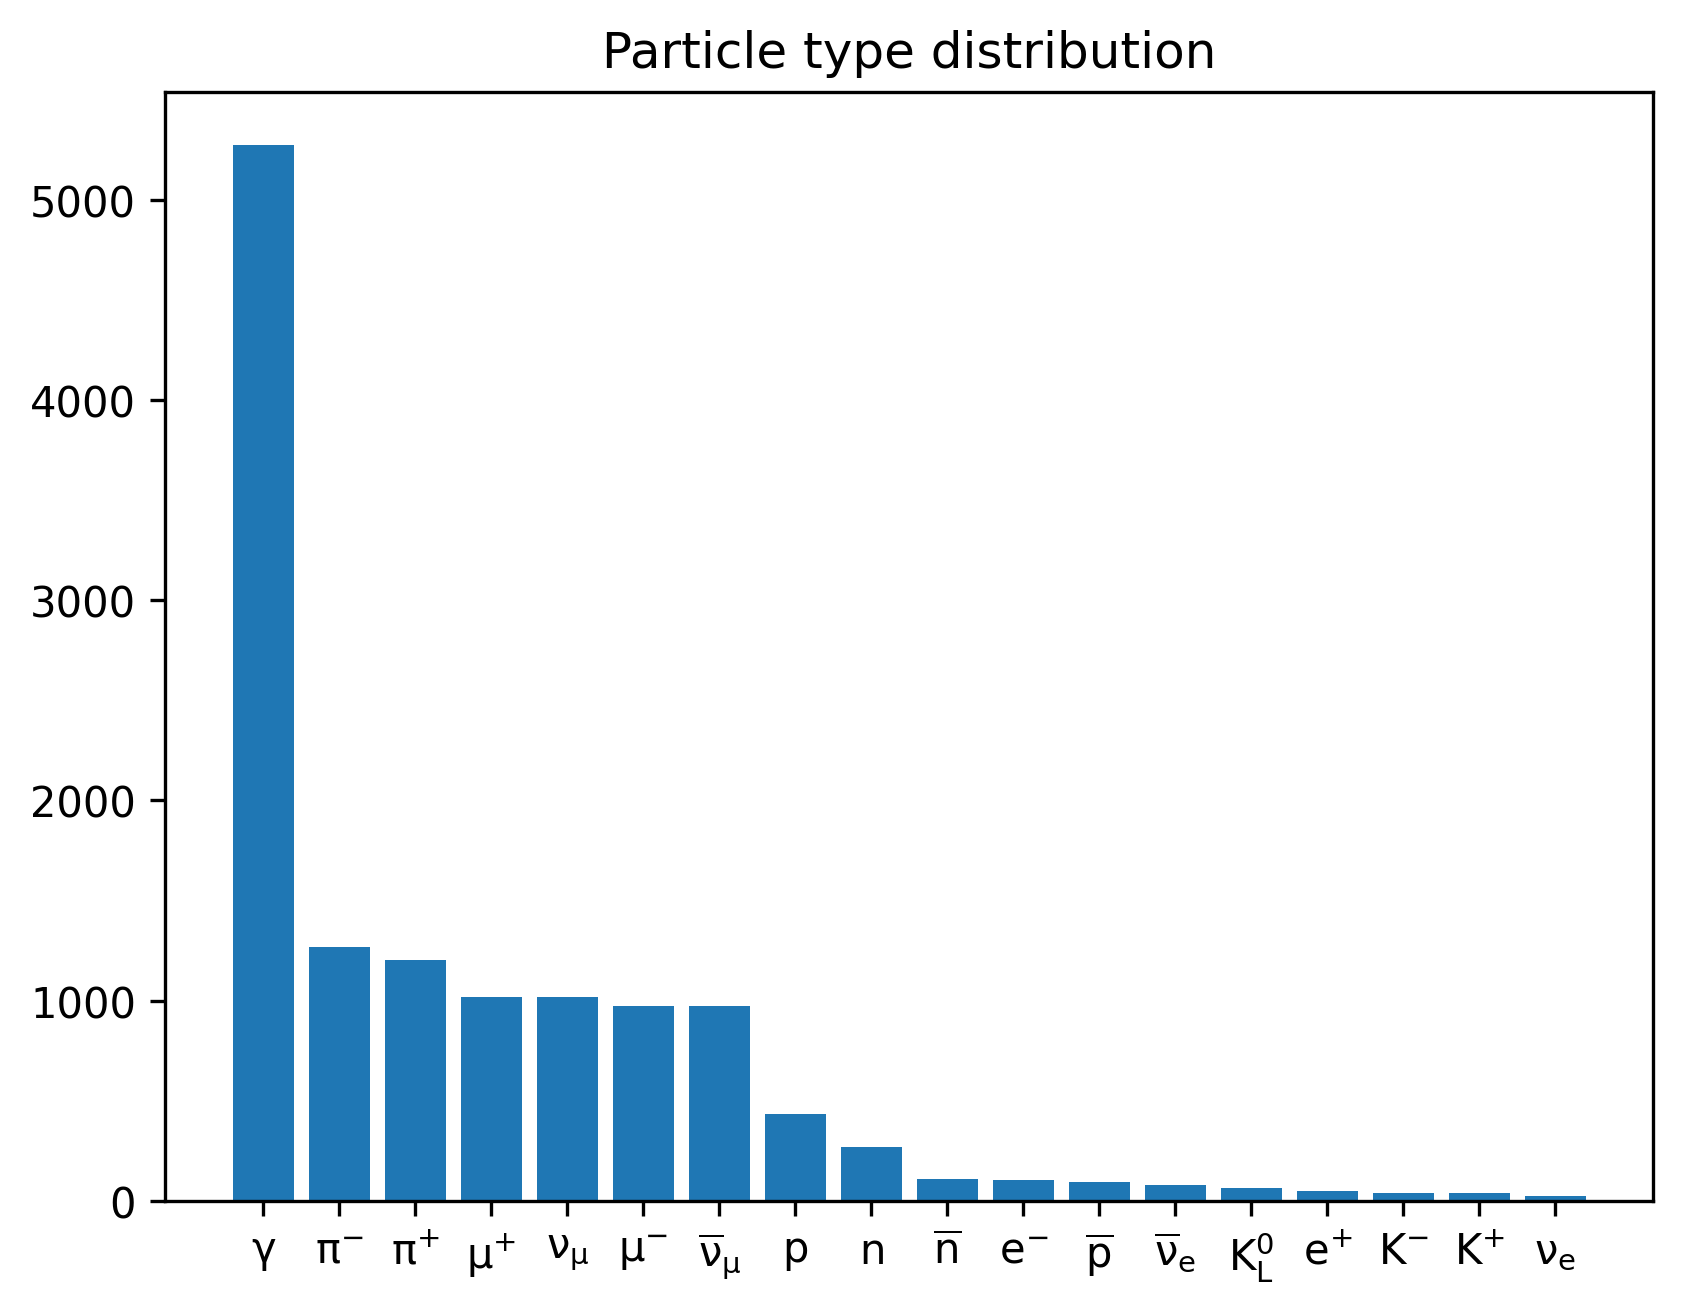

In [202]:
cascade_analysis.plot_ptypes_dist(from_ = 0)

In [ ]:
cascade_analysis.plot_energy_list(pids = [-11, 11, -12, 12, -13, 13, -14, 14, 
                                          -211, 211])

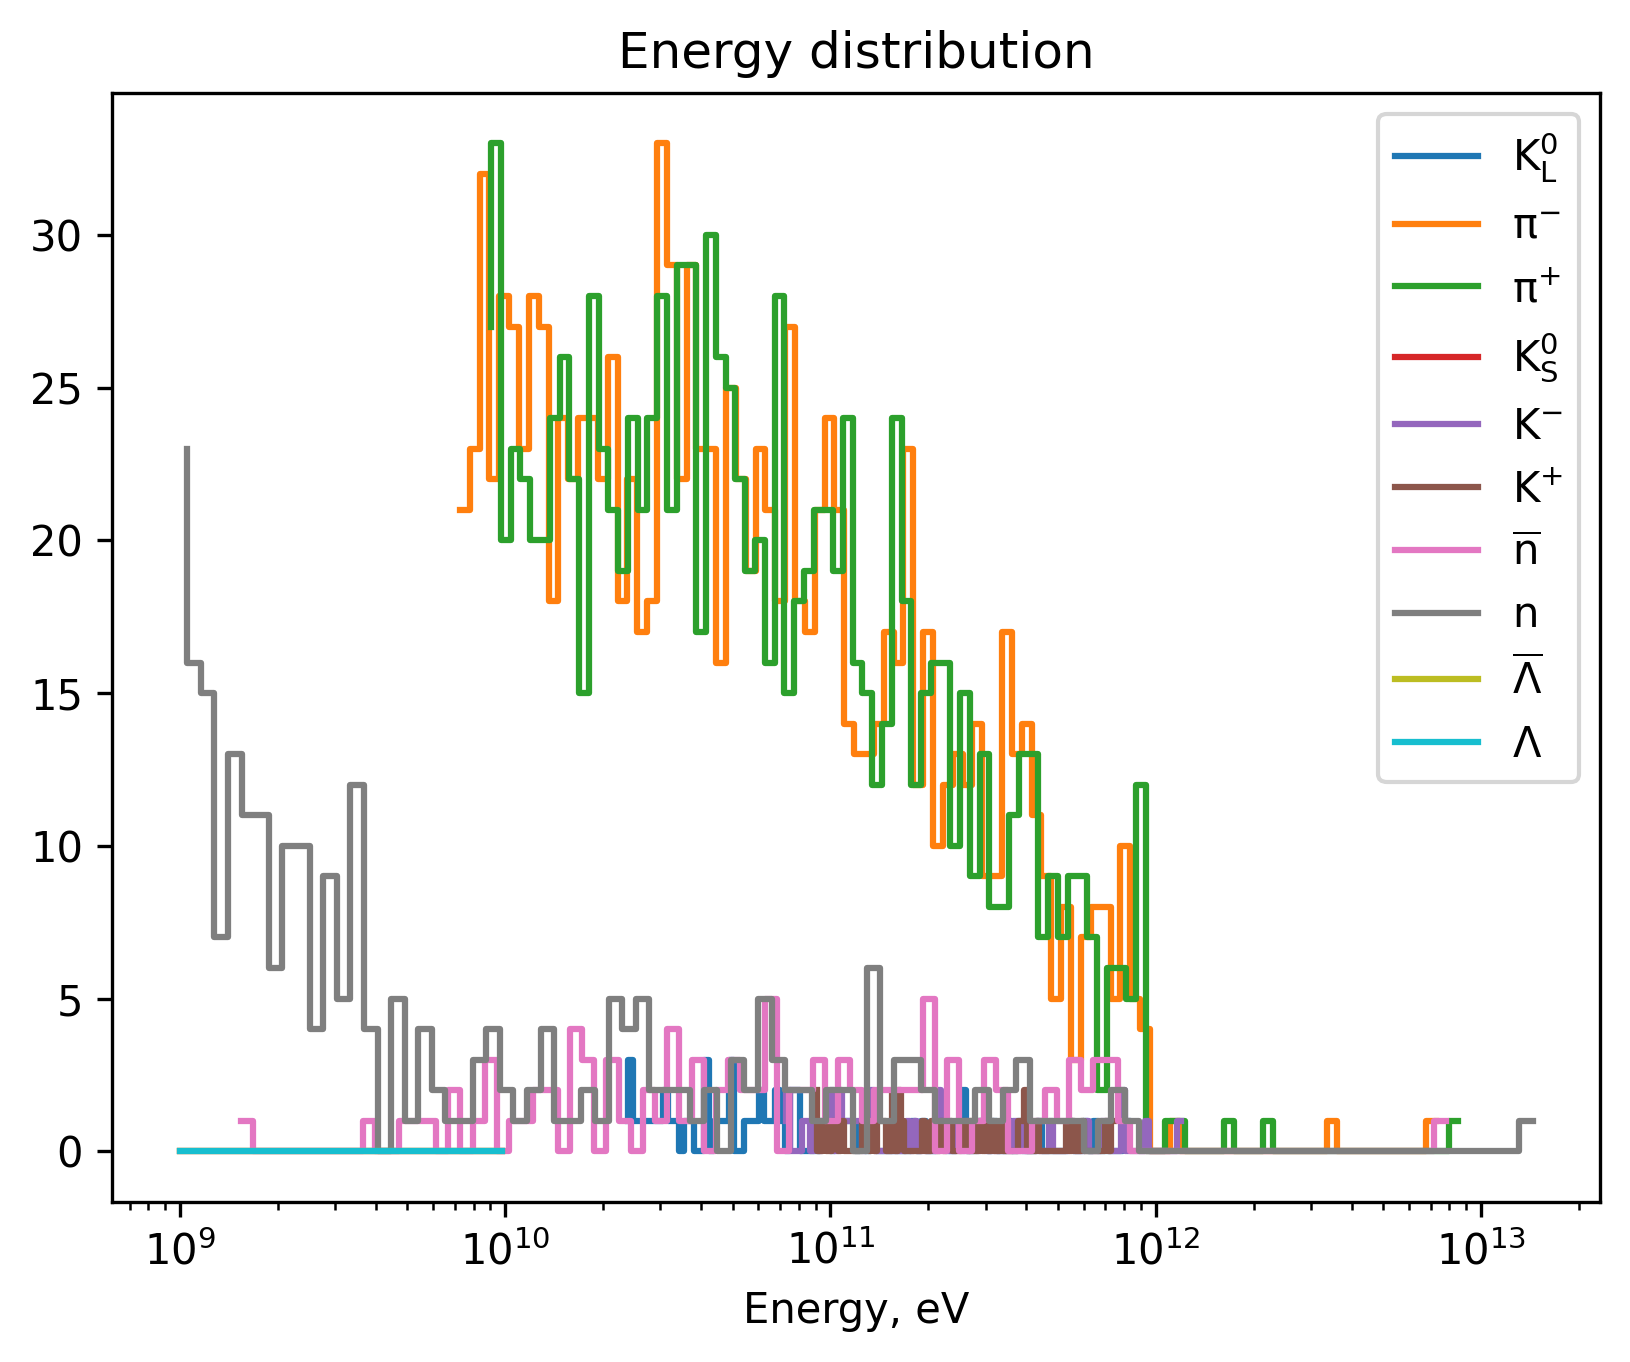

In [203]:
cascade_analysis.plot_energy_list(pids = list(cascade_analysis.cascade_driver.mceq_mixed_pdgs))

In [204]:
mceq_wrapper.collector.clear()
mceq_wrapper.collector.add_particles(cas_driver.final_stack.valid(),
                                     cas_driver.runs_number)

In [205]:
mceq_wrapper.collector.print_info(True)

On grid:
  Total number of particles: 12198
  Total energy: 9.989556e+05 GeV


Not put on a grid (block 1) :
 833 particles
 pdg_ids: [-14, -13, -12, -11, 11, 12, 13, 14, 22, 2212]
 counts: [183, 40, 57, 3, 60, 2, 38, 177, 171, 102]
 energies: ['7.668e+00', '1.389e+00', '5.787e-02', '7.855e-02', '1.619e-01', '1.174e-01', '1.705e+00', '7.420e+00', '7.734e+00', '3.665e+00'] GeV
 share of total energy: ['2.556e-01', '4.631e-02', '1.929e-03', '2.619e-03', '5.397e-03', '3.915e-03', '5.684e-02', '2.474e-01', '2.578e-01', '1.222e-01']

 total energy: 3.000e+01 GeV
 energy range: [3.173e-05, 7.925e-02] GeV
 slant depth range: [1.083e+02, 1.196e+03] g/cm2
 reason: outside of energy_bins=[7.943e-02, 1.995e+06], n_bins=74


In [206]:
mceq_wrapper.solve_collector()

In [207]:
mceq_wrapper.get_fluxes(pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("pi0", "pi0"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ])
mceq_dist = mceq_wrapper

In [183]:
mceq_normal = MceqWrapper(pdg_id = 2212,
                           energy = 1e6,
                           theta_deg = 30,
                           slant_depths=[1, 10, 100, 600, 900, 1000, 1195],
                           energy_range=[1e-1, 2e6])
mceq_normal.solve_single_particle()
mceq_normal.get_fluxes(pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("pi0", "pi0"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ])

Text(0, 0.5, 'Counts/bin/primary')

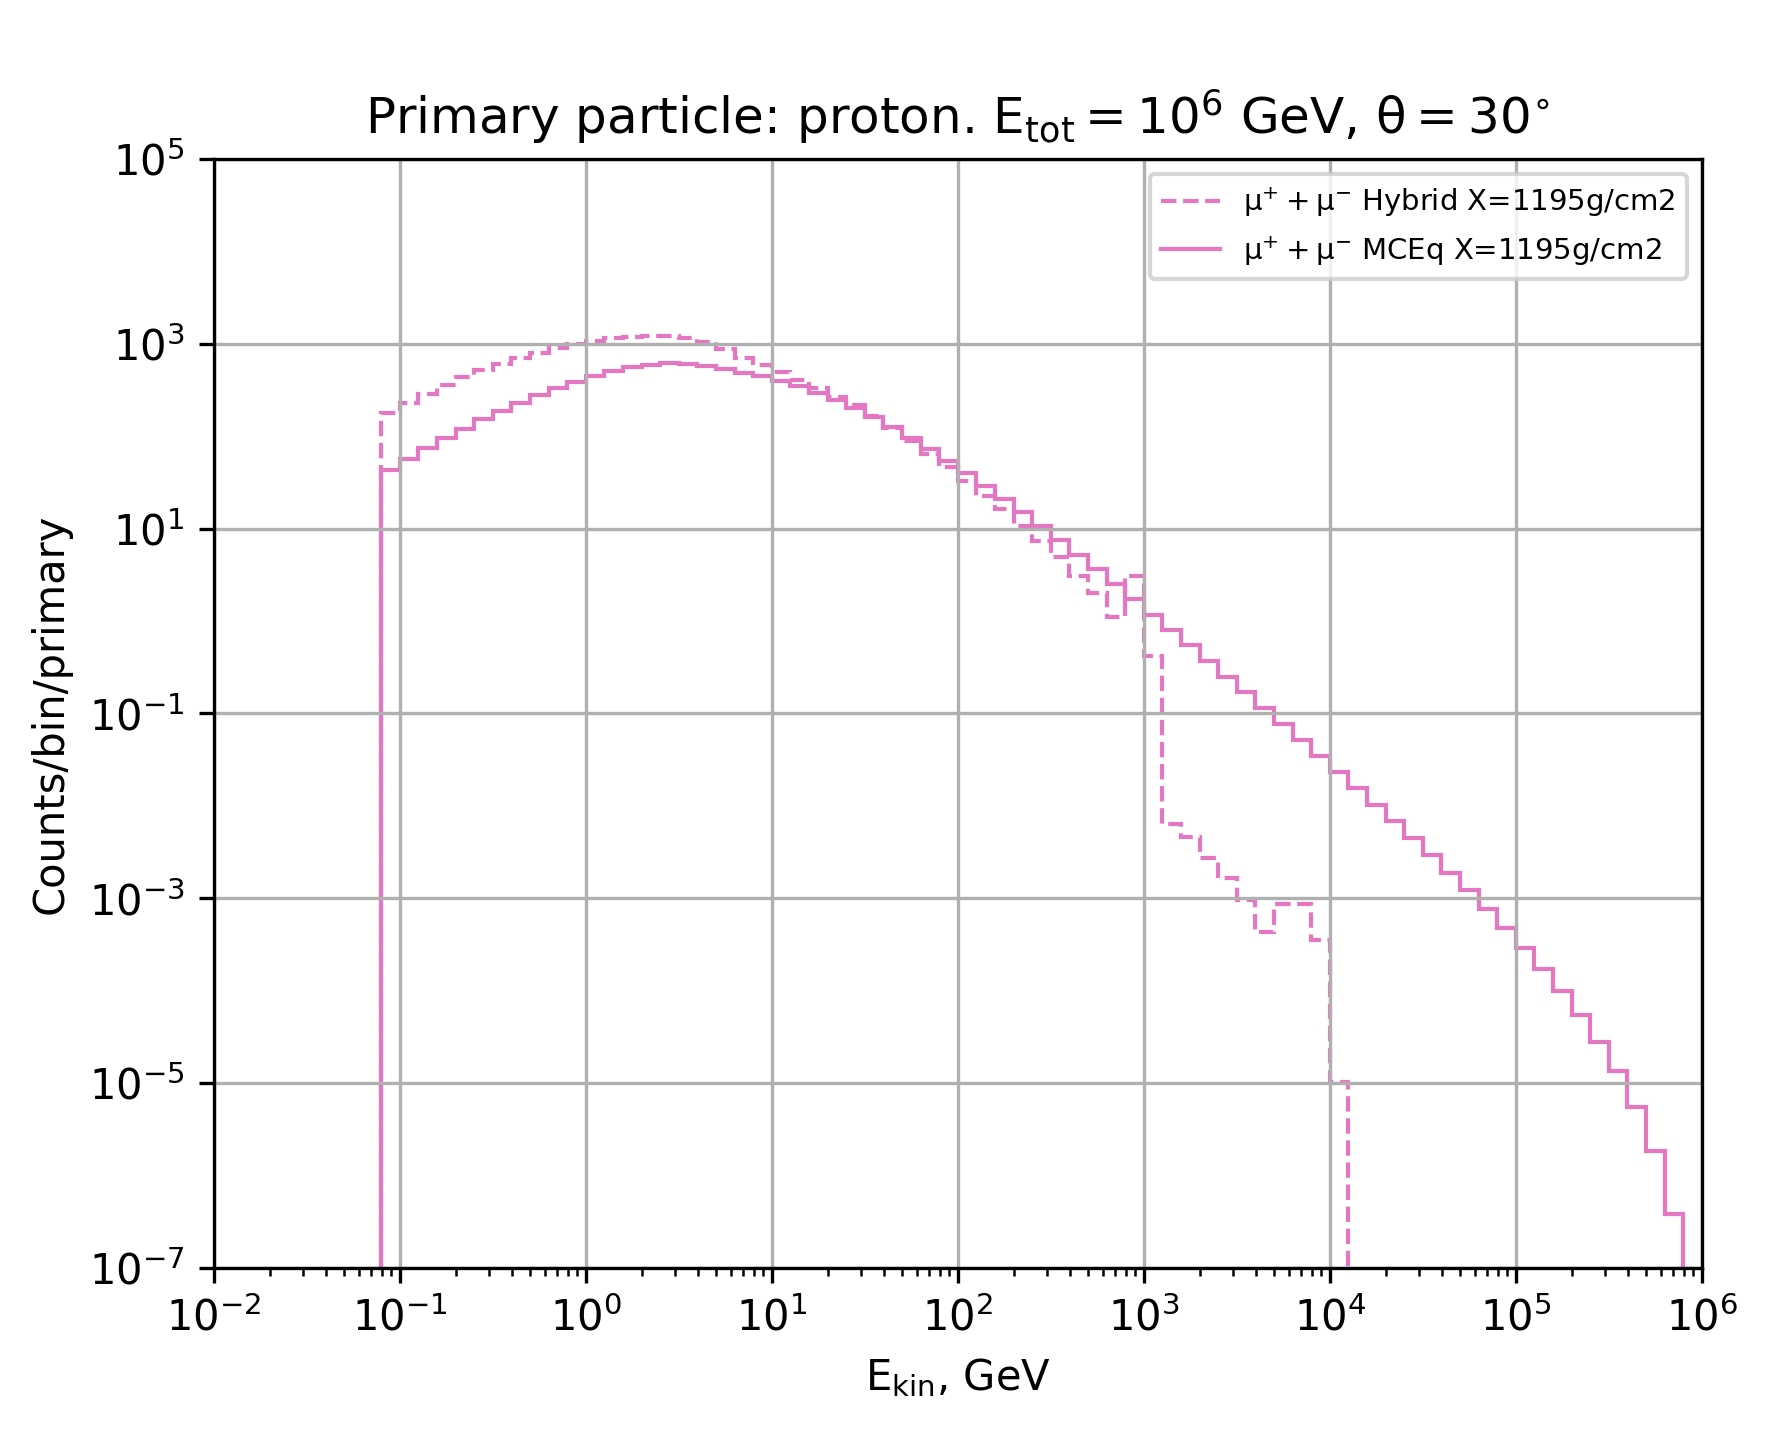

In [211]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ixdepth = 0
# plt.stairs(mceq_dist.flux[ixdepth]["pi0"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
#            linestyle='-',
#            color = line_colors[0])
ixdepths = range(len(mceq_dist.slant_depths))
ixdepths = [ 6]
for ixdepth in ixdepths:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid X=" + f"{mceq_dist.slant_depths[ixdepth]}g/cm2", 
            linestyle='--',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_normal.flux[ixdepth]["mu"], mceq_normal.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq X=" + f"{mceq_normal.slant_depths[ixdepth]}g/cm2", 
            # linestyle='--',
            color = line_colors[ixdepth])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 1e6)
plt.ylim(1e-7, 1e5)
plt.legend(fontsize="7")
plt.grid()
plt.title("\nPrimary particle: proton. " 
          +  r"$E_{tot}=10^{6}$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")

Text(0, 0.5, 'Counts/bin/primary')

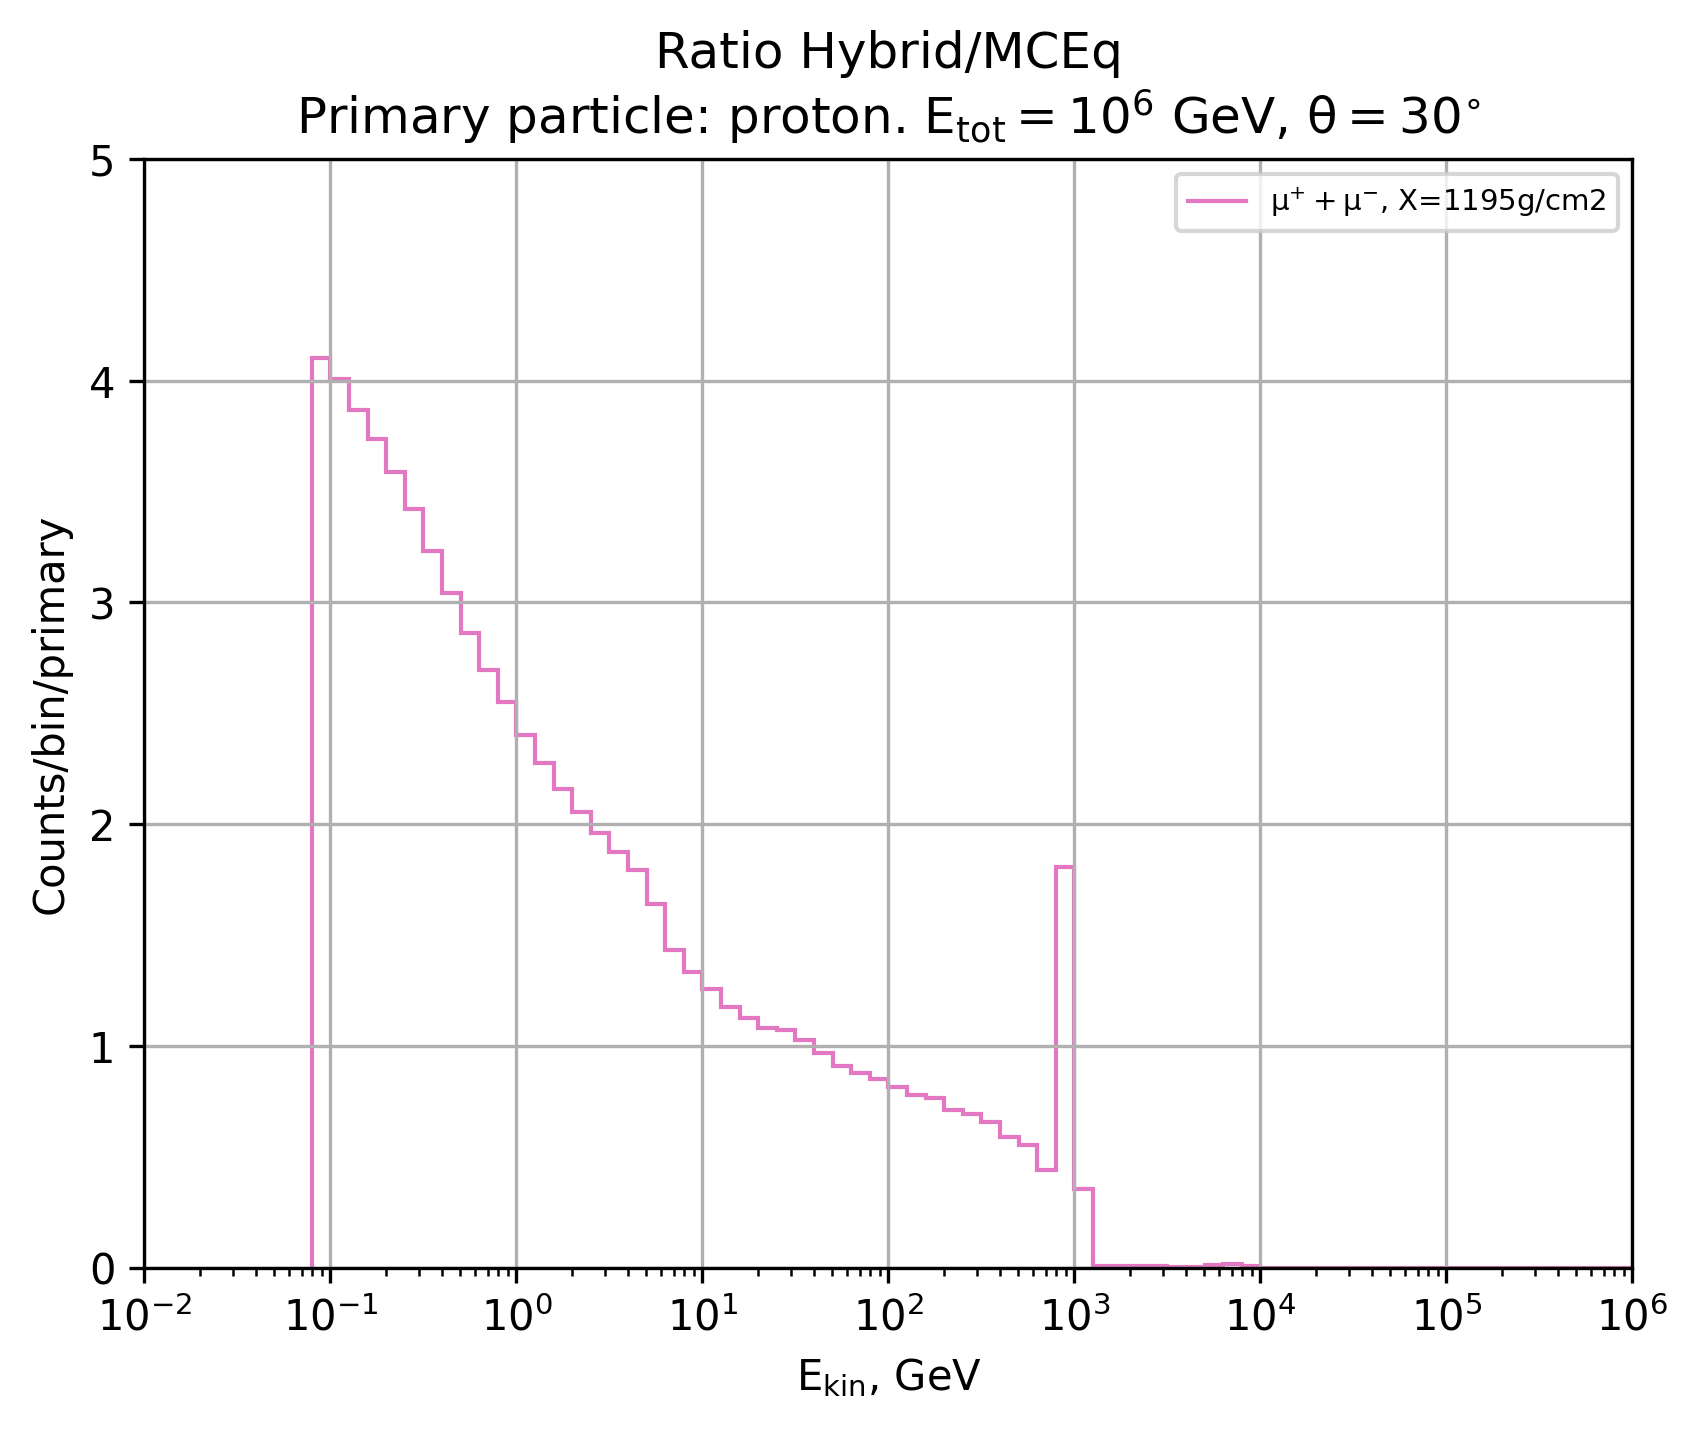

In [214]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ixdepth = 0
# plt.stairs(mceq_dist.flux[ixdepth]["pi0"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
#            linestyle='-',
#            color = line_colors[0])
ixdepths = range(len(mceq_dist.slant_depths))
ixdepths = [6]
for ixdepth in ixdepths:
    # plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
    #         label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_dist.slant_depths[ixdepth]}", 
    #         linestyle='--',
    #         color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["mu"]/mceq_normal.flux[ixdepth]["mu"], mceq_normal.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$, X=" + f"{mceq_normal.slant_depths[ixdepth]}g/cm2", 
            # linestyle='--',
            color = line_colors[ixdepth])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
# plt.yscale("log")
plt.xlim(1e-2, 1e6)
plt.ylim(0, 5)
plt.legend(fontsize="7")
plt.grid()
plt.title("Ratio Hybrid/MCEq"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=10^{6}$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")

In [89]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

/tmp/ipykernel_1147112/3457148209.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


Text(0, 0.5, 'Counts/bin/primary')

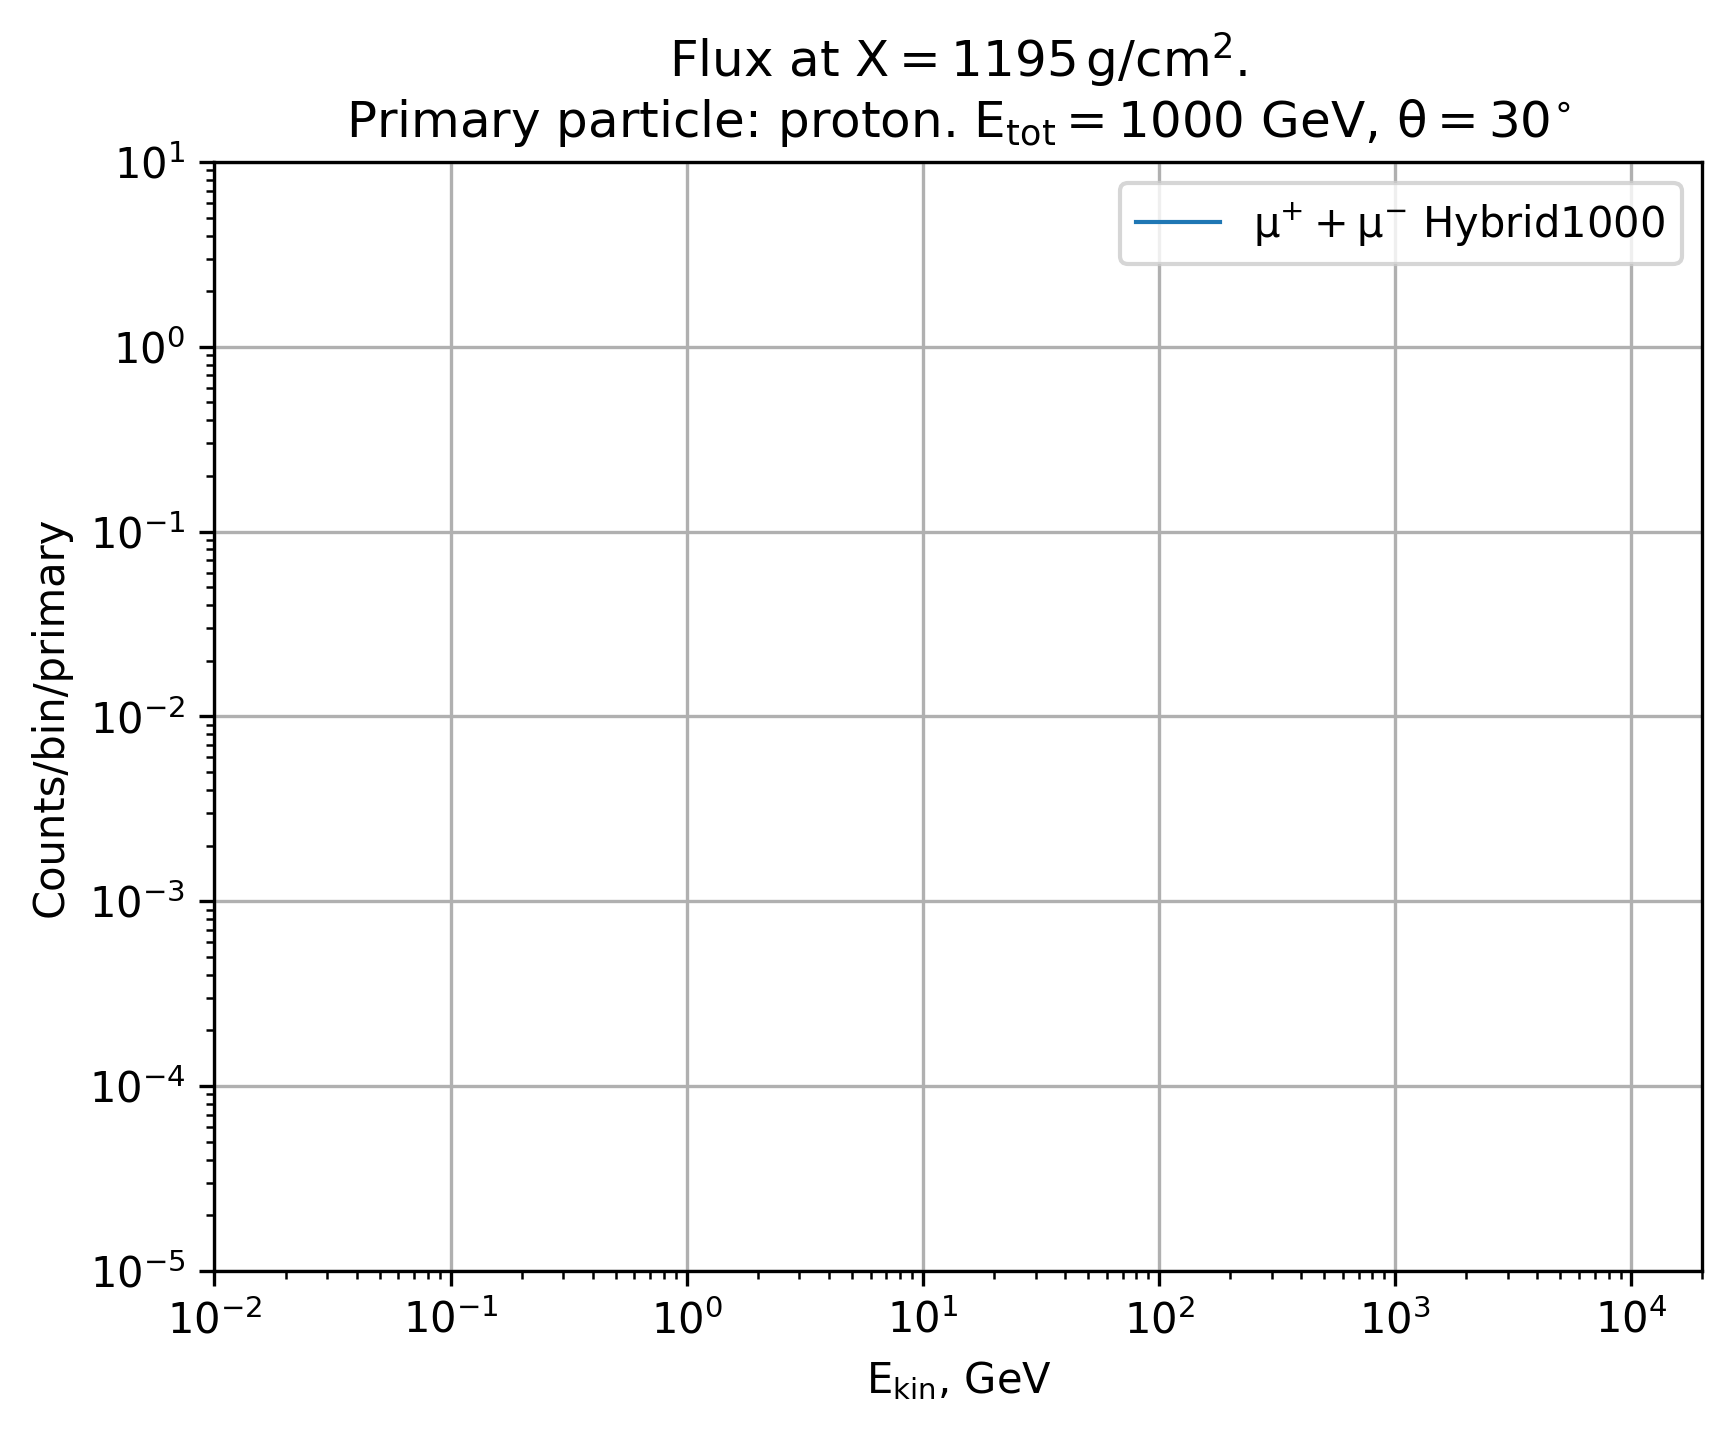

In [59]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["pi0"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

# plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
#            linestyle='--',
#            color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")

Text(0, 0.5, 'Counts/bin/primary')

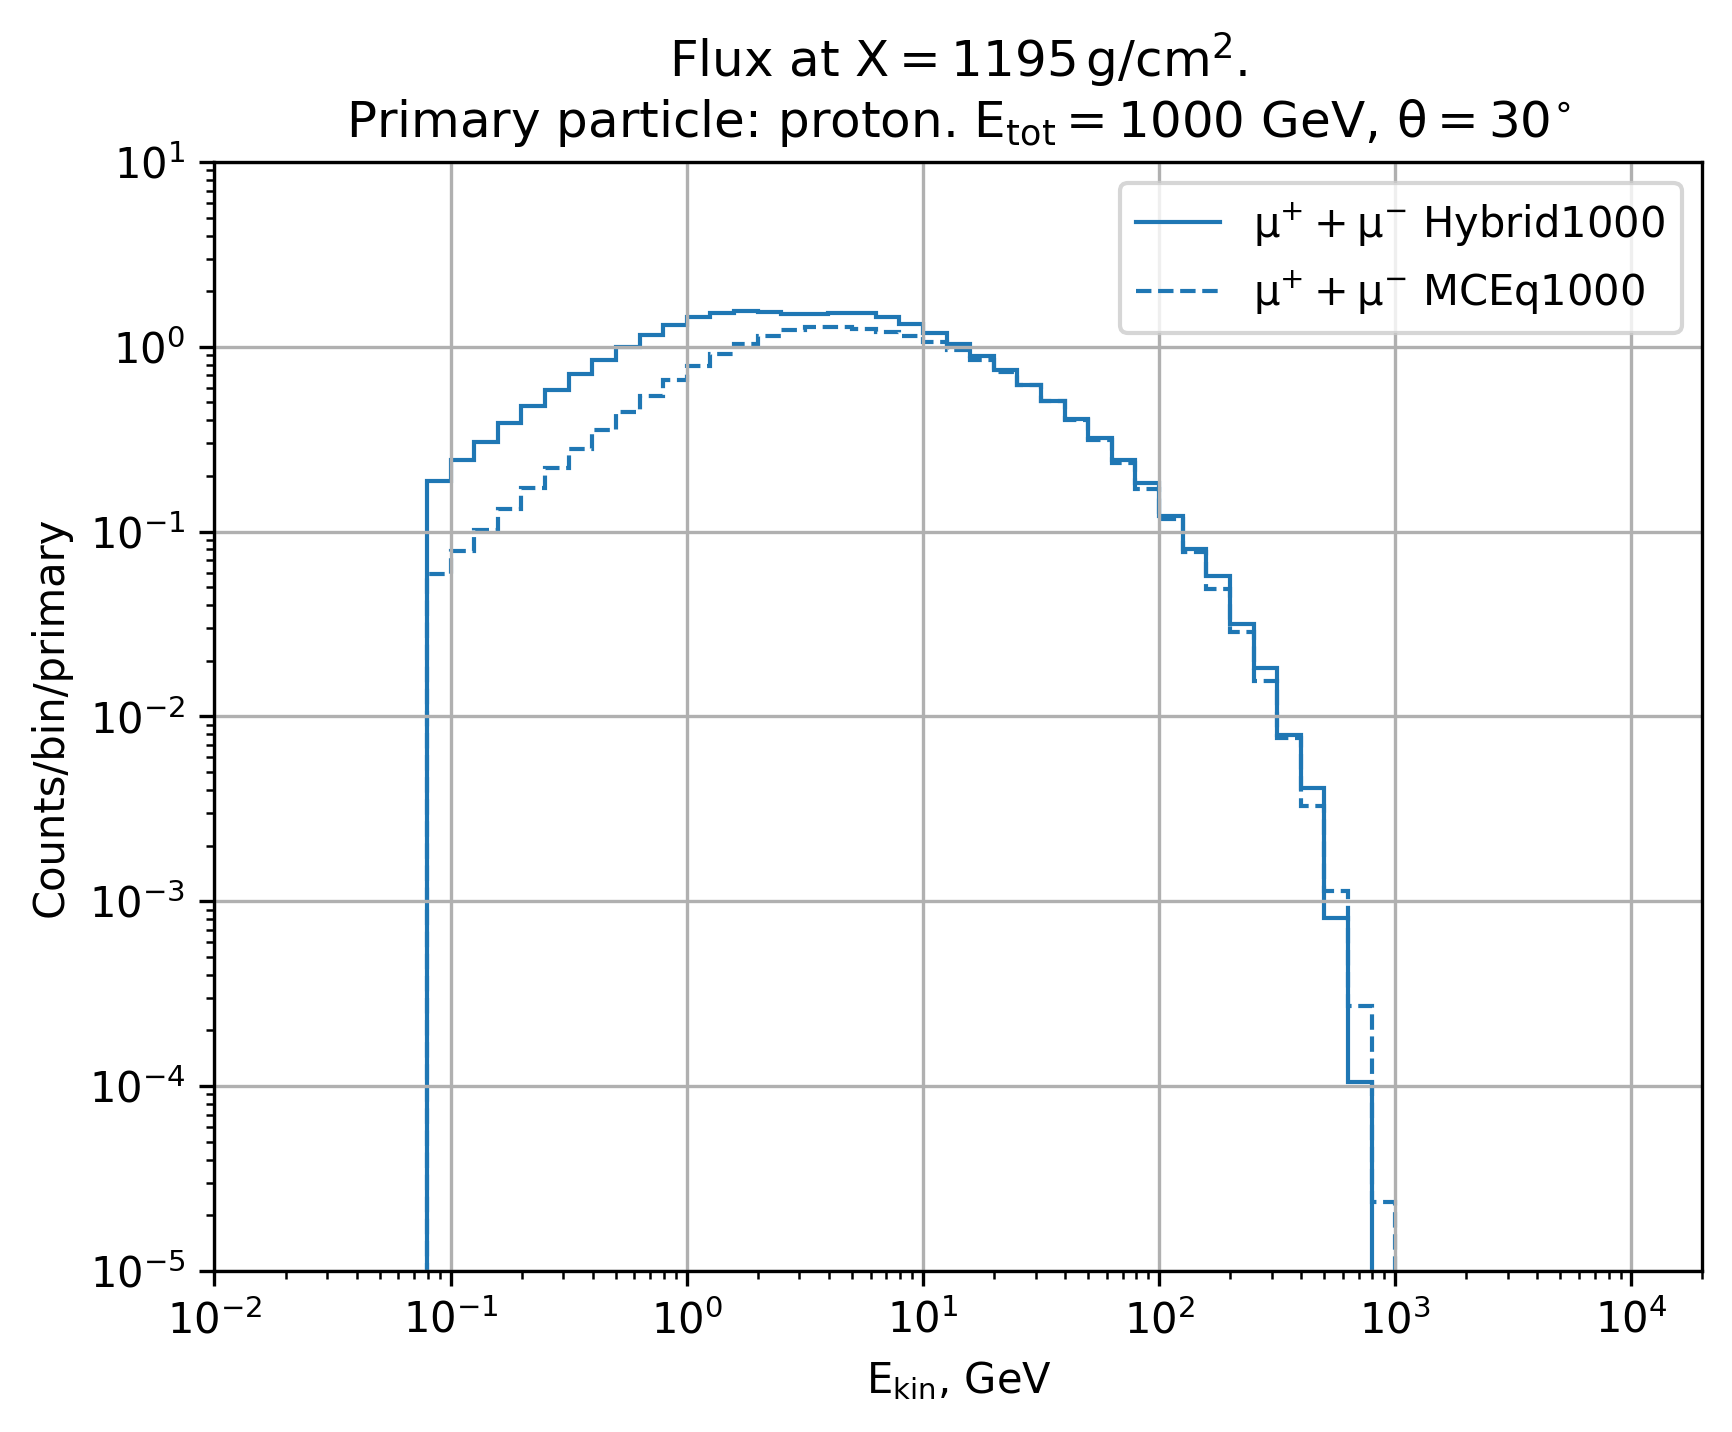

In [67]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, -12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
           linestyle='--',
           color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
# plt.savefig('01_nomuon_decay_flux.svg')

Text(0, 0.5, 'Counts/bin/primary')

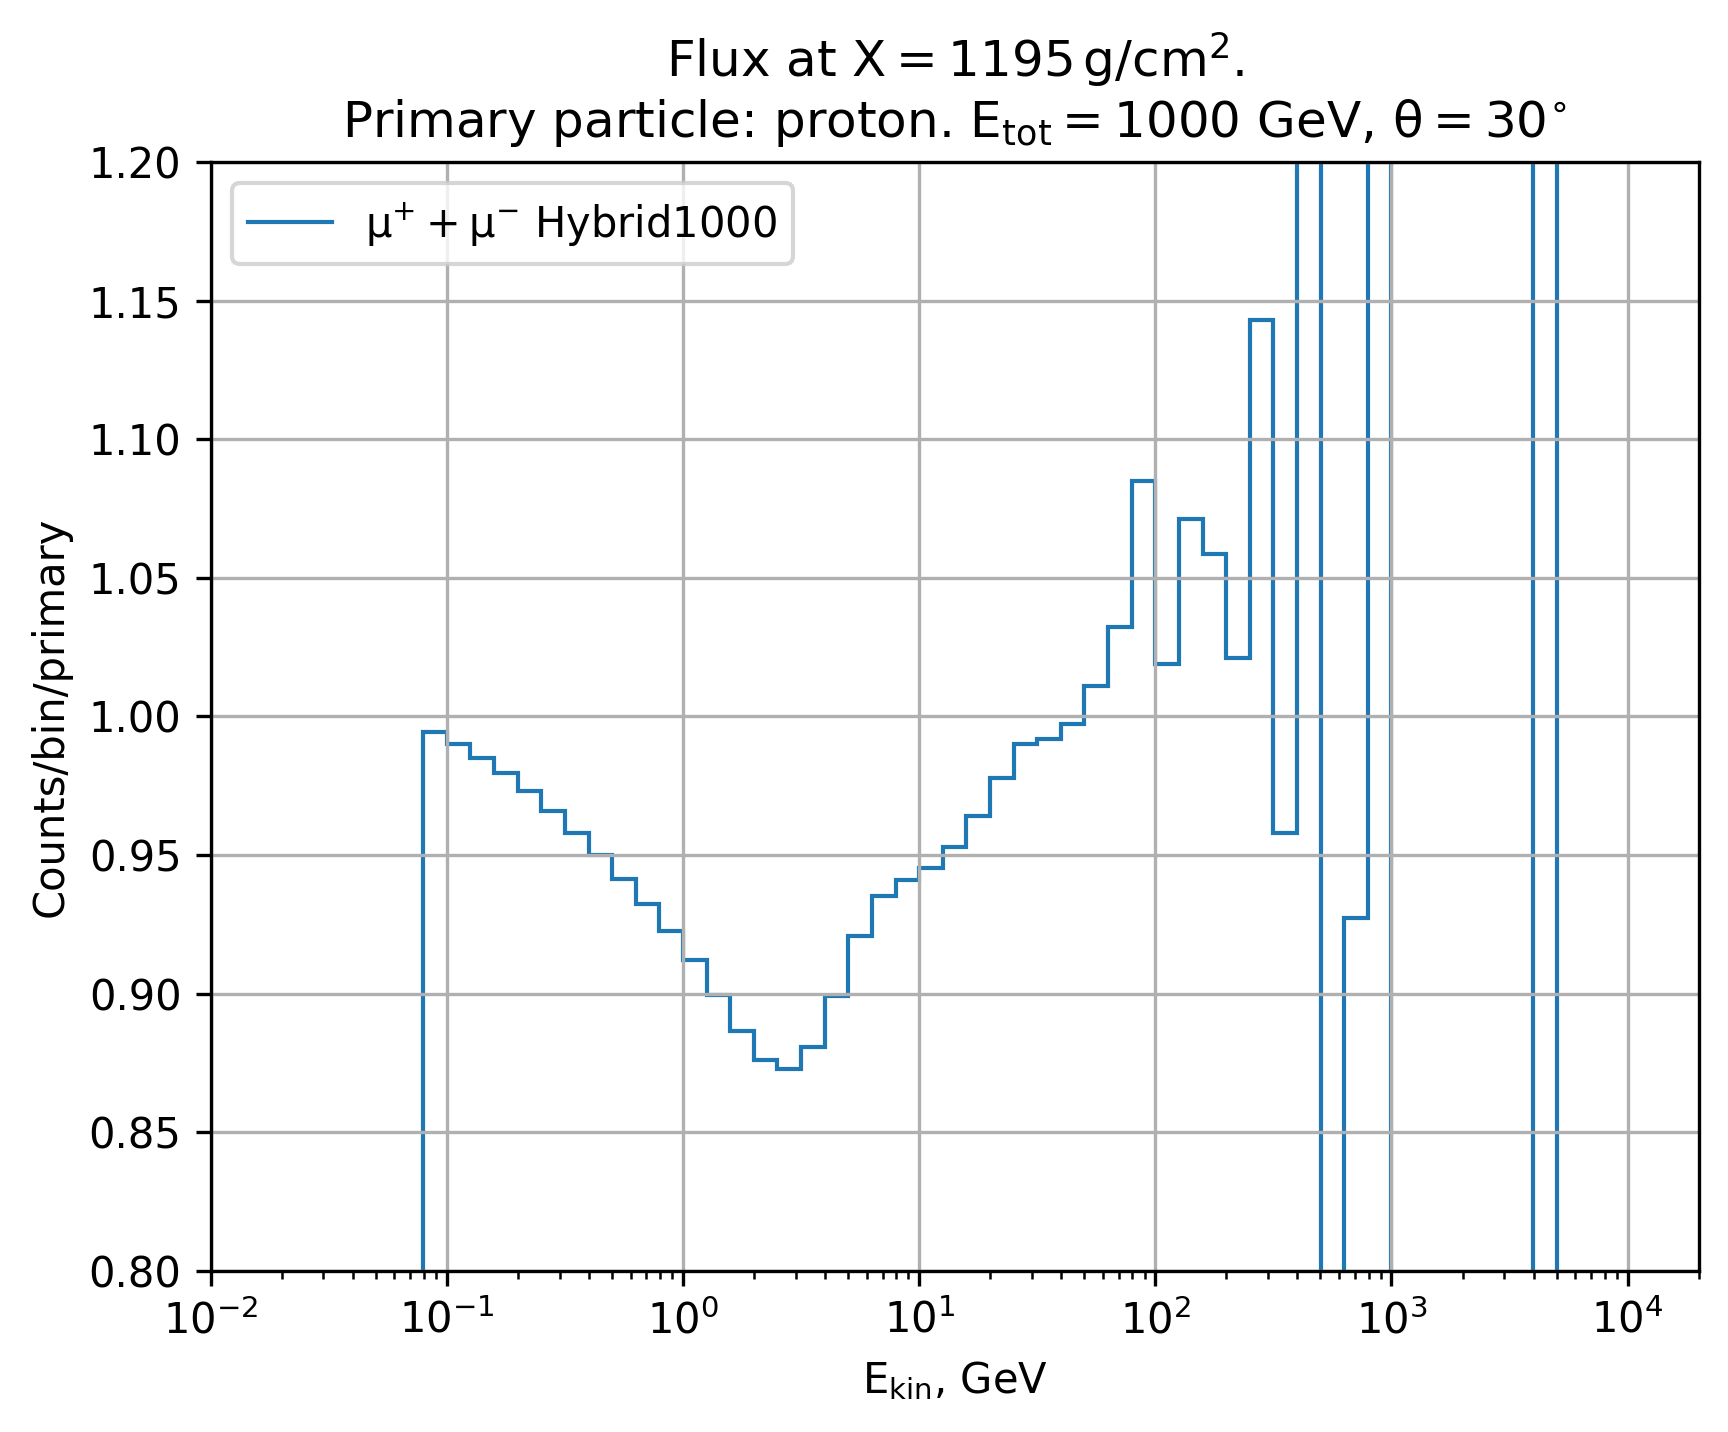

In [48]:
ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"]/mceq_loss.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

# plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
#            linestyle='--',
#            color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
# plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(0.8, 1.2)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")

In [155]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

{22: 13336, 2212: 6004, -13: 5775, 14: 5775, 13: 5514, -14: 5514, 11: 2664, -12: 2588, 2112: 951, -11: 164, 12: 88, 111: 73, -2212: 65, 211: 60, -211: 60, 3122: 9, -2112: 2, -3122: 2}


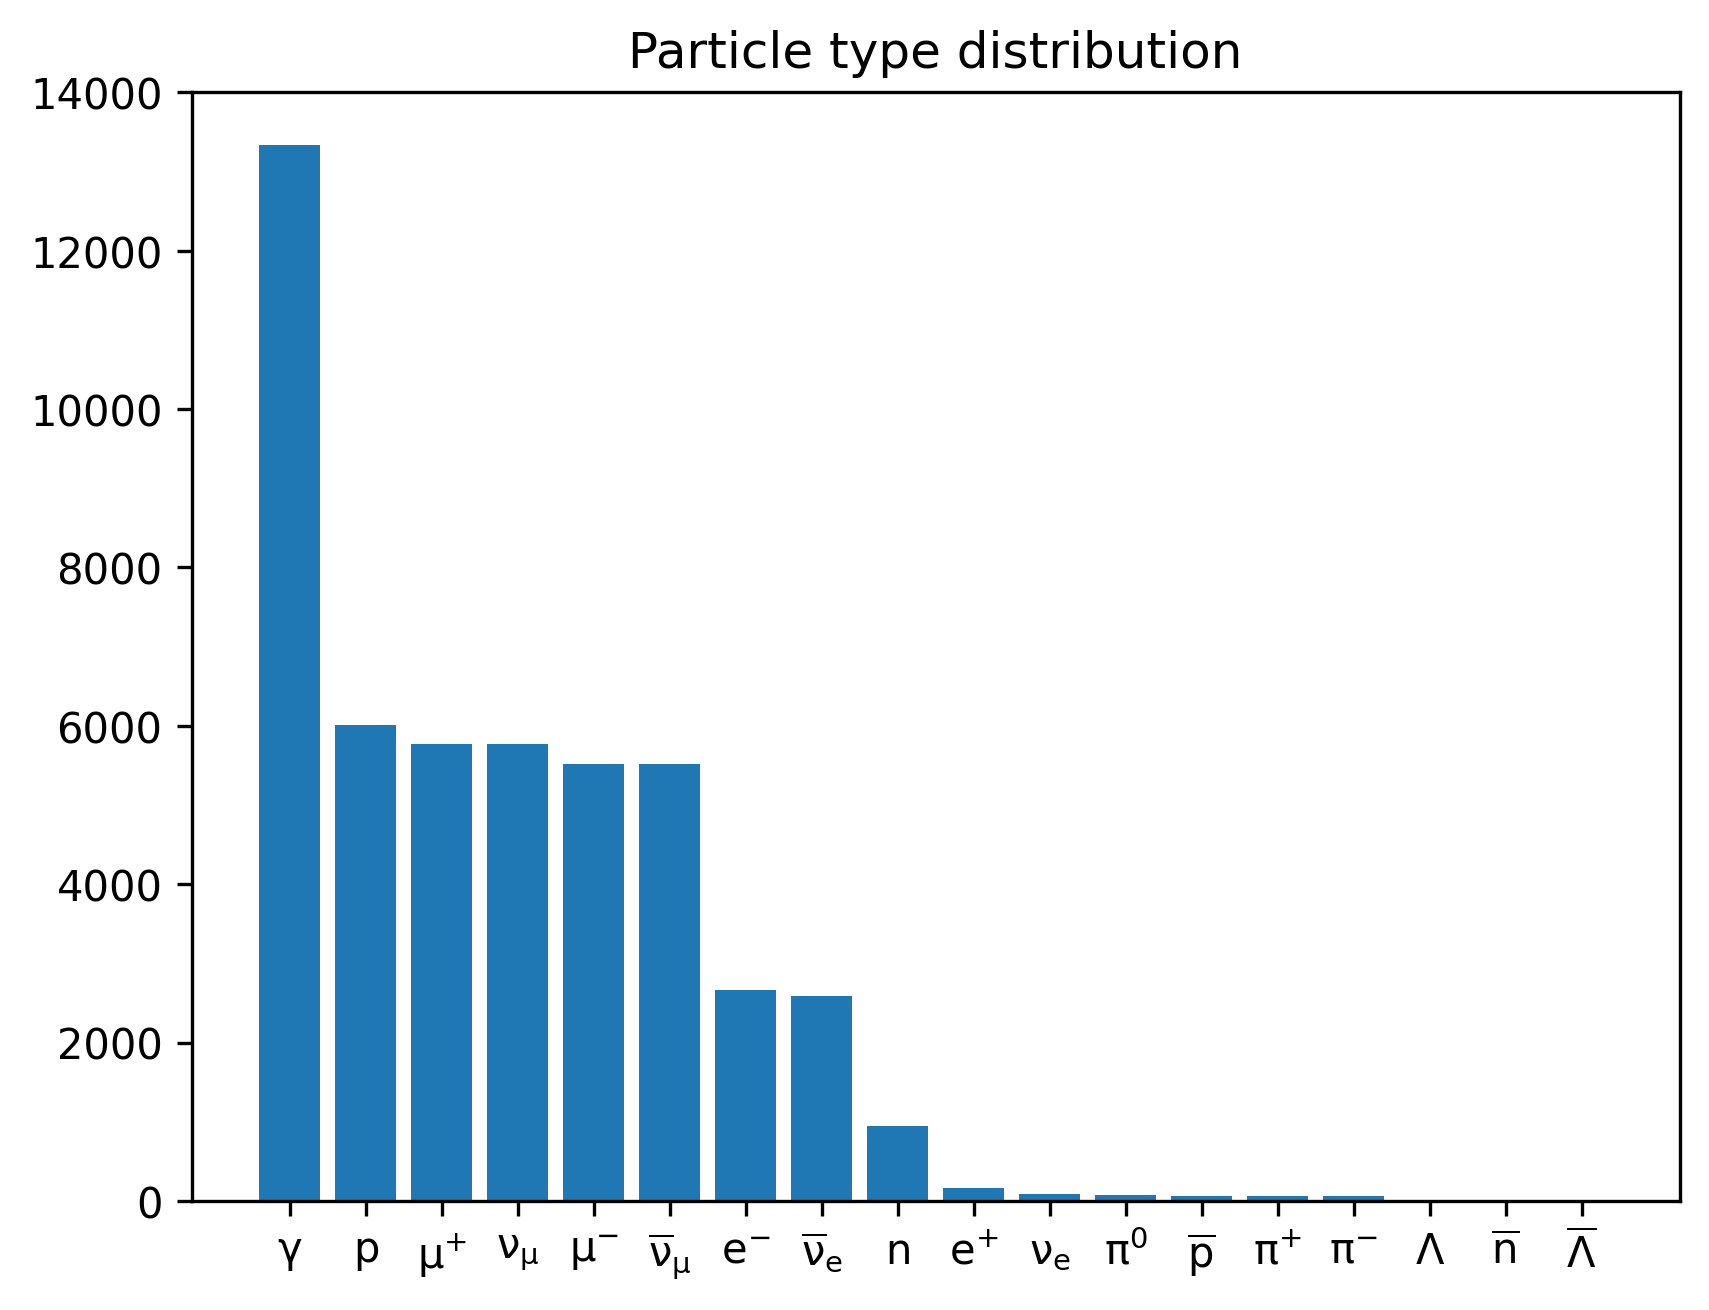

In [233]:
cascade_analysis.plot_ptypes_dist(from_ = 0)

In [ ]:
final_particles = cas_driver.get_final_particles().valid()

In [120]:
from mceq_comparison import MCEQDistributions

In [94]:
mceq_loss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[3e-2, 2e2],
                 slant_depths=[66, 143, 638, 1193],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


/hetghome/antonpr/MCEq/MCEq/solvers.py:40: RuntimeWarning: overflow encountered in multiply
  phc += (imc.dot(phc) + dmc.dot(ric[step] * phc)) * dxc[step]
/hetghome/antonpr/MCEq/MCEq/solvers.py:40: RuntimeWarning: invalid value encountered in add
  phc += (imc.dot(phc) + dmc.dot(ric[step] * phc)) * dxc[step]


In [258]:
mceq_loss1 = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[5e-2, 2e2],
                 slant_depths=[66, 143, 638, 1193],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [259]:
mceq_noloss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-2, 2e2],
                 slant_depths=[66, 143, 638, 1195],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-"),
                     ("pi_mu", "pi_mu+", "pi_mu-"),
                     ("k_mu",  "k_mu+", "k_mu-"),
                     ("K0_mu", "K0_mu+", "K0_mu-"),
                     ("prcas_mu", "prcas_mu+", "prcas_mu-"),
                     ("prres_mu", "prres_mu+", "prres_mu-"),
                     ],
                 interaction_model = "DPMJET-III-19.1",
                 generic_losses_all_charged = False, 
                 enable_energy_loss = False, 
                 muon_helicity_dependence = False,
                 disable_decays = [-13, 13, -211, 211],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))
                #  disable_decays = [-13, 13, -211, 211, 111]
mceq_dist = mceq_noloss

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


Histogram of -211 with mass 0.13957039000000002
Histogram of 211 with mass 0.13957039000000002
Histogram of -211 with mass 0.13957039000000002
Histogram of 211 with mass 0.13957039000000002


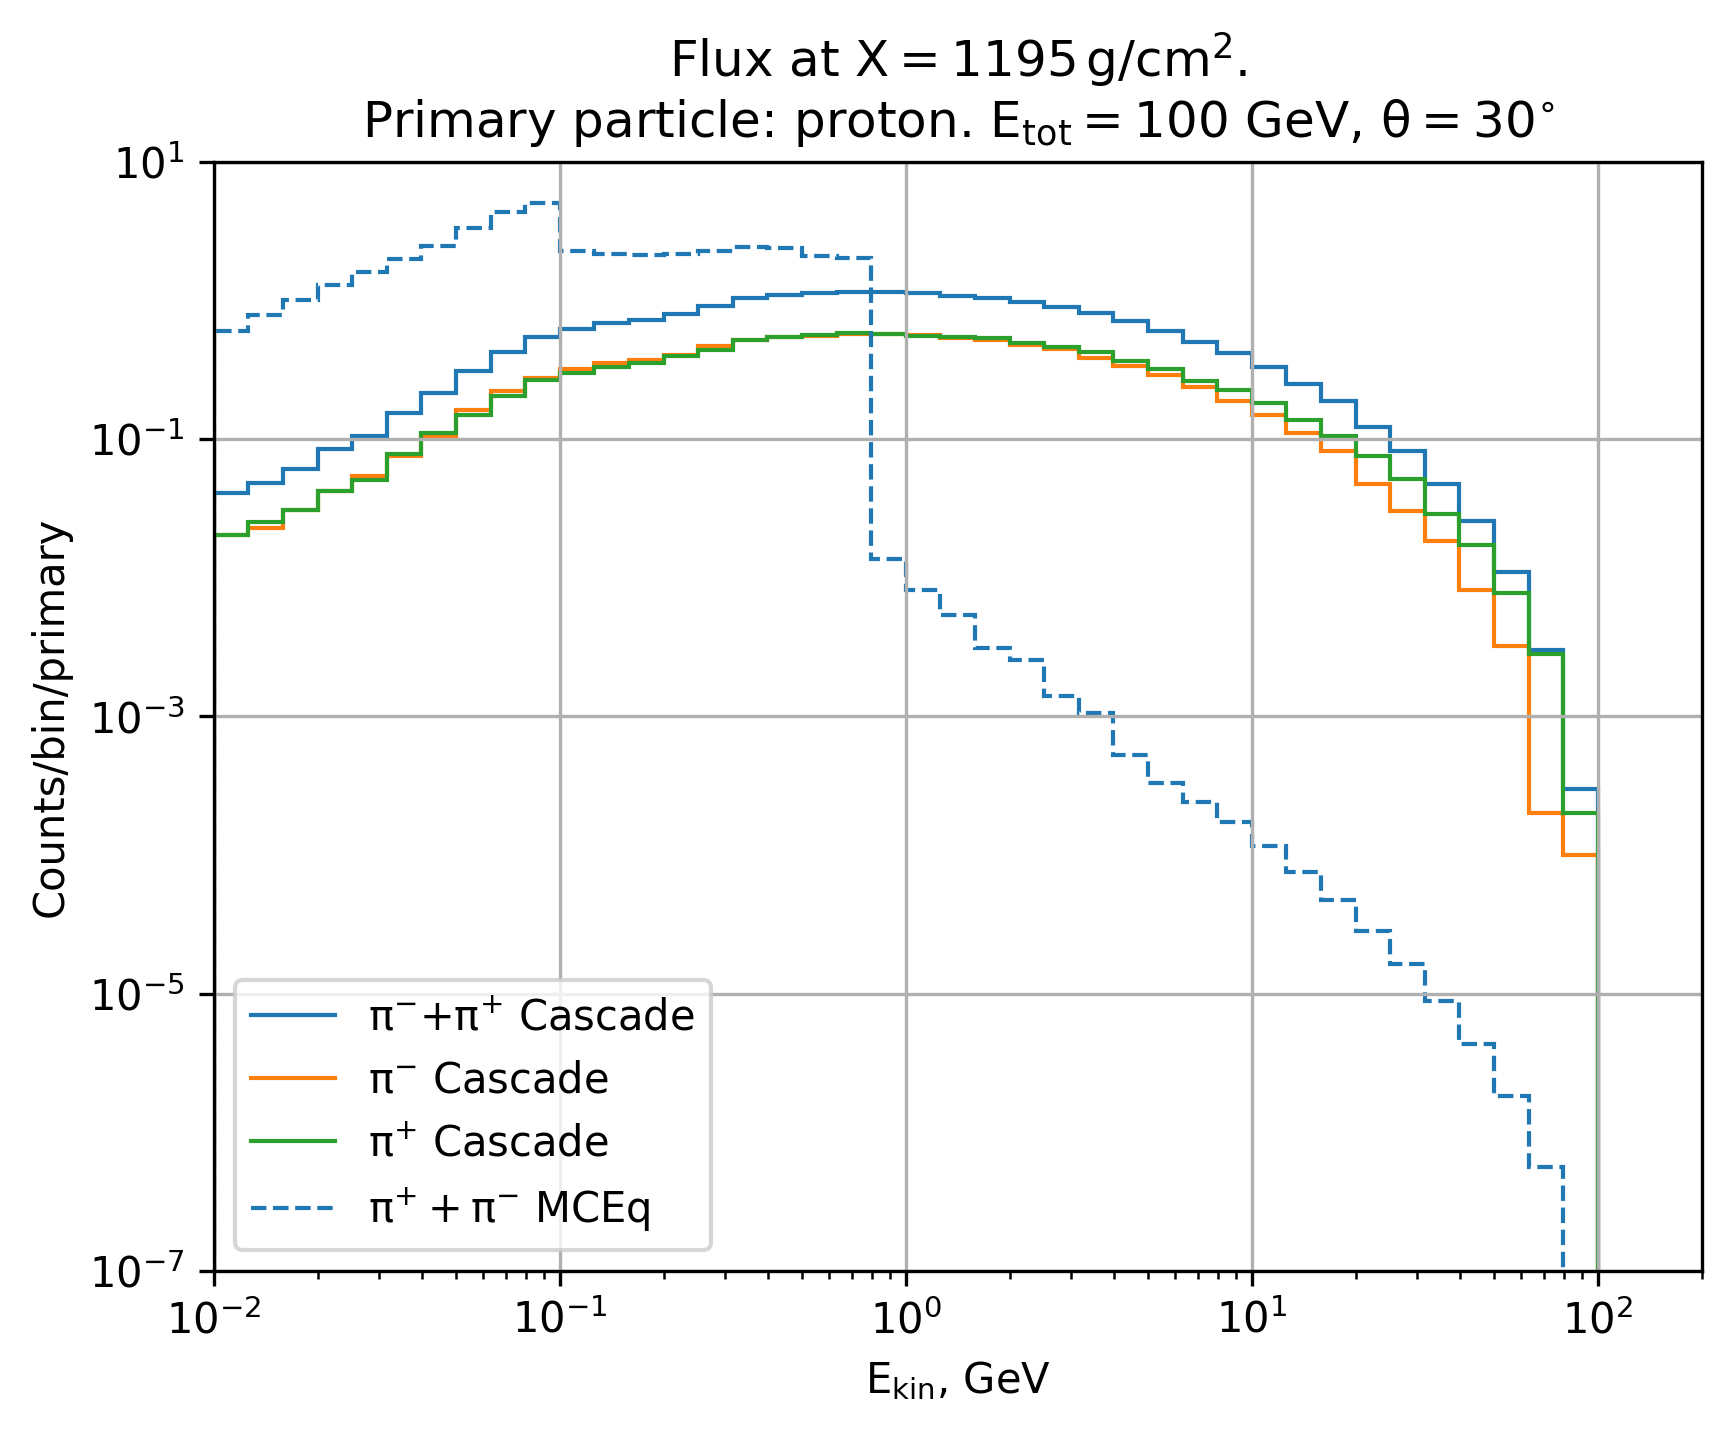

In [265]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211,), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (211,), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])


ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["pi"], mceq_dist.e_bins, 
           label = r"${\pi}^{+} + {\pi}^{-}$ MCEq", linestyle='--',
           color = line_colors[0])

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e2)
plt.ylim(1e-7, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
plt.savefig('04_nomuon_decay_piflux.svg')

Histogram of -13 with mass 0.10565837550000001
Histogram of 13 with mass 0.10565837550000001


Text(0, 0.5, 'Counts/bin/primary')

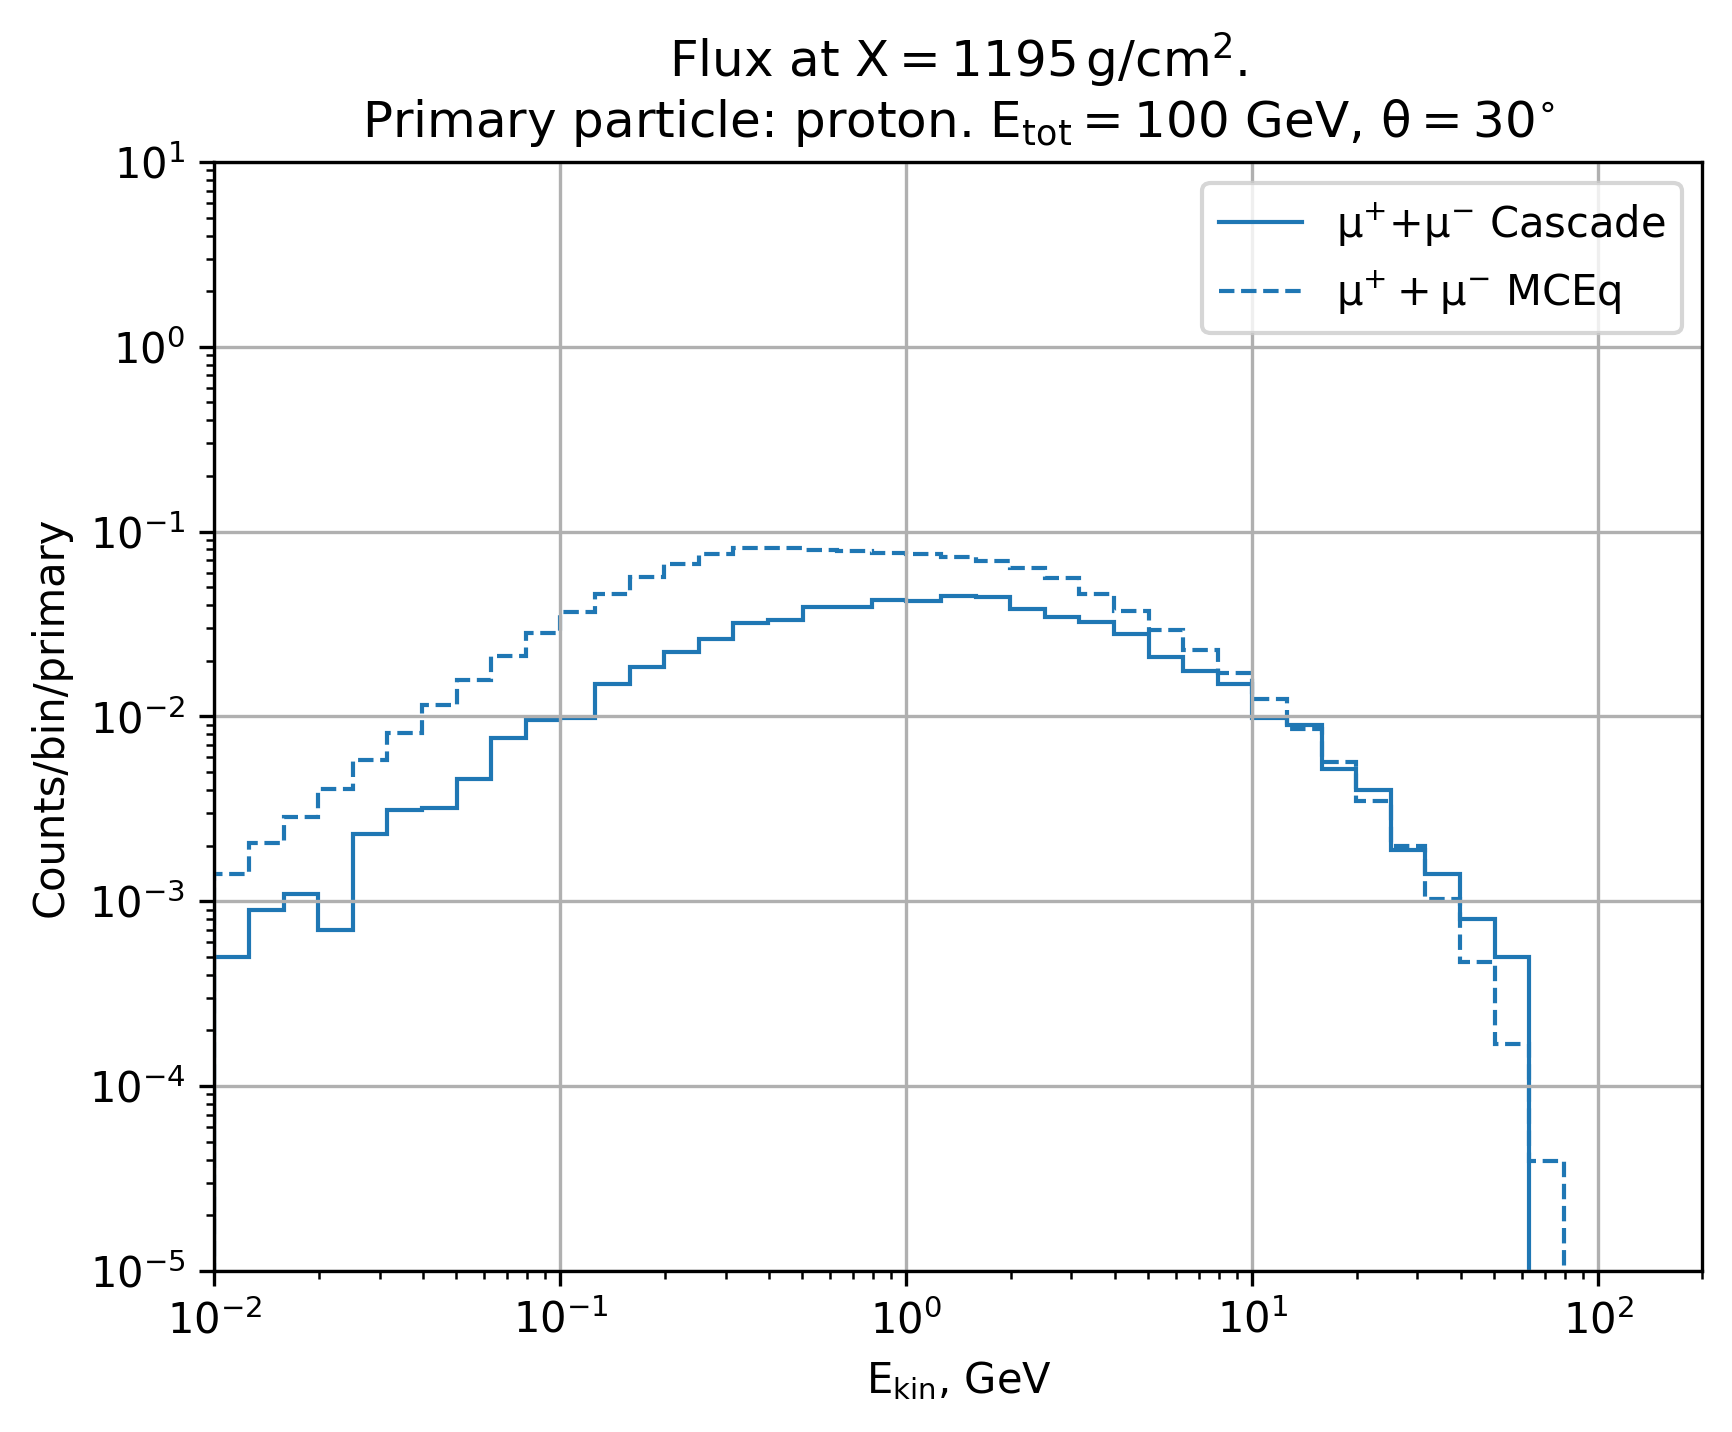

In [263]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, -12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq", linestyle='--',
           color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e2)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
# plt.savefig('01_nomuon_decay_flux.svg')

Histogram of -13 with mass 0.10565837550000001
Histogram of 13 with mass 0.10565837550000001
Histogram of -12 with mass 0.0
Histogram of 12 with mass 0.0
Histogram of -14 with mass 0.0
Histogram of 14 with mass 0.0


/tmp/ipykernel_2052987/1296374379.py:4: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins,
/tmp/ipykernel_2052987/1296374379.py:9: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins,
/tmp/ipykernel_2052987/1296374379.py:14: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins,


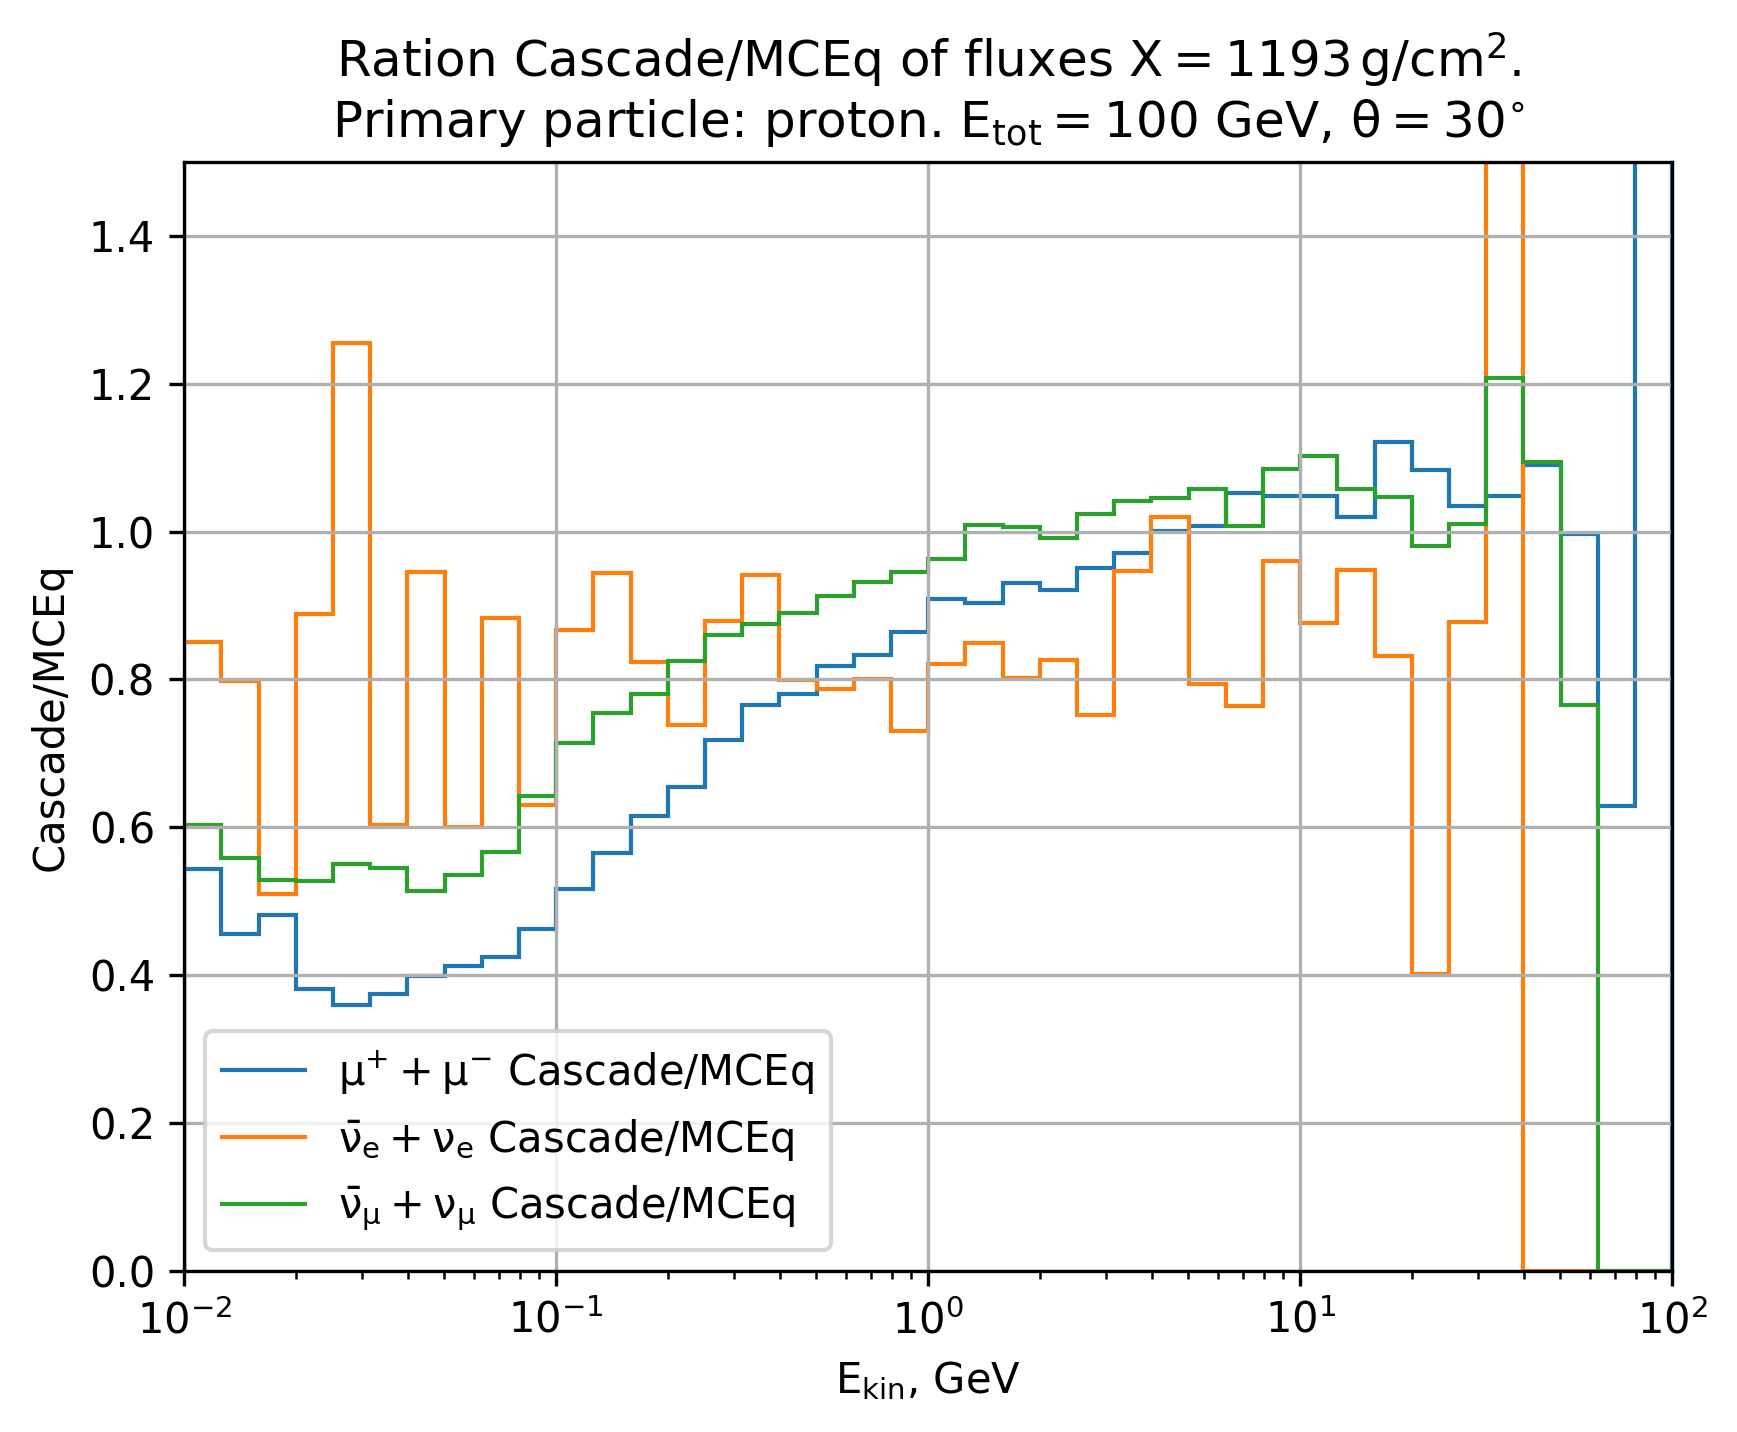

In [241]:
bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
ixdepth = 3
plt.stairs(hist/mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Cascade/MCEq", linestyle='-')

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, 12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
plt.stairs(hist/mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
           label = r"$\bar{\nu}_{e} + {\nu}_{e}$ Cascade/MCEq", linestyle='-')

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
plt.stairs(hist/mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
           label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ Cascade/MCEq", linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# # plt.stairs(hist, bins, label = label, linestyle='-')
# plt.stairs(hist/mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"${e}^{+} + {e}^{-}$ mceq no loss", linestyle='-')

# plt.stairs(mceq_loss.flux["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq loss", linestyle='--')

plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.title("Ration Cascade/MCEq of fluxes " +  r"$X = 1193\, g/cm^2.$"+
          "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Cascade/MCEq")
plt.savefig('01_nomuon_decay_ratio.svg')

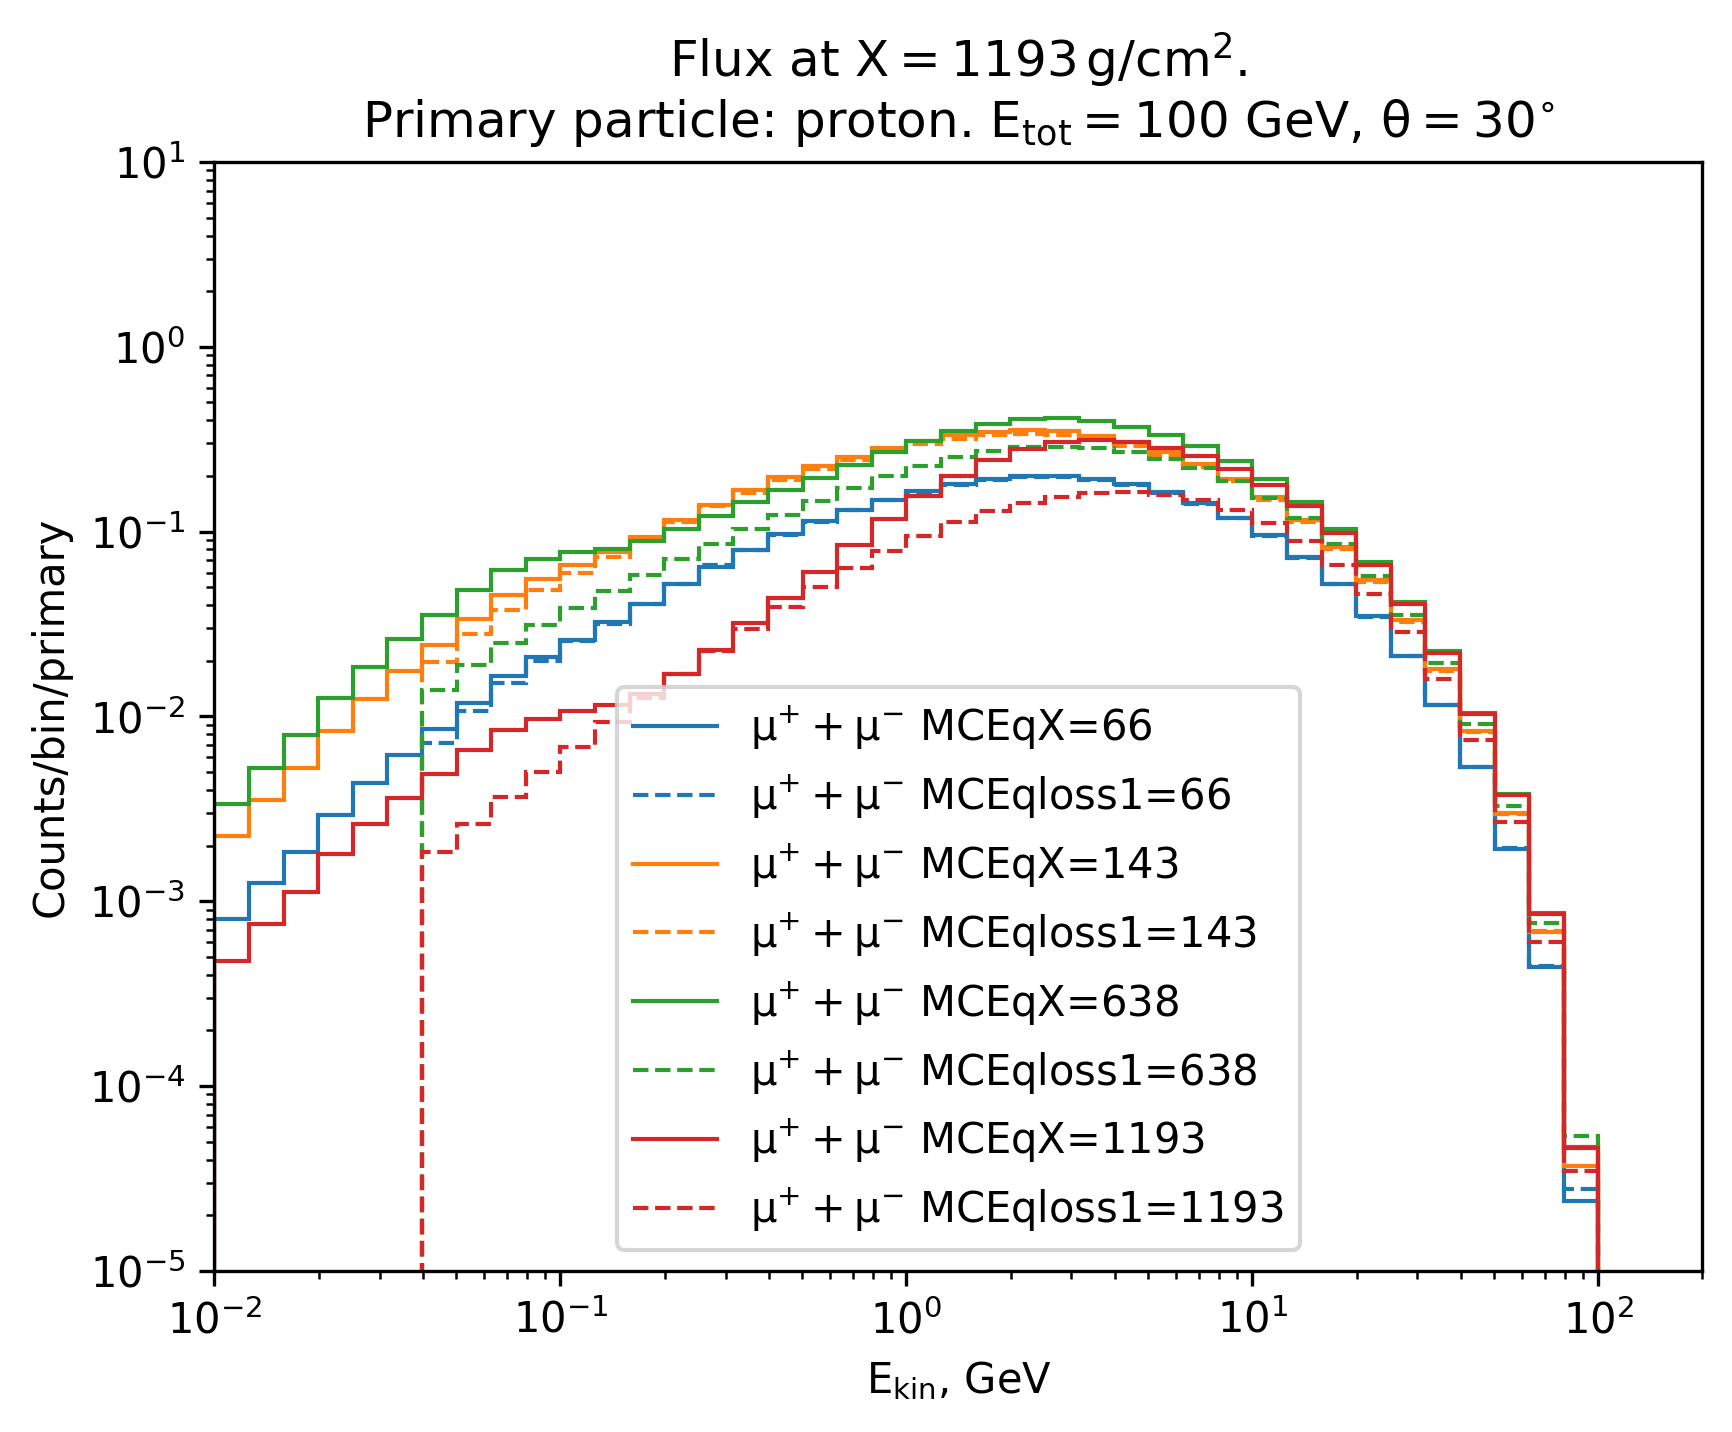

In [158]:
ixdepth = 0
xdepths_list = [0, 1, 2, 3]
# xdepths_list = [2, 3]

for ixdepth in xdepths_list:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_dist.slant_depths[ixdepth]}", linestyle='-',
            color = line_colors[ixdepth])
    
#     plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#             label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_loss.slant_depths[ixdepth]}", 
#             linestyle='--',
#             color = line_colors[ixdepth])
    
    plt.stairs(mceq_loss1.flux[ixdepth]["mu"], mceq_loss1.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"loss1={mceq_loss1.slant_depths[ixdepth]}", 
            linestyle='--',
            color = line_colors[ixdepth])


    # plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

    # plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
    # plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
    #         color = line_colors[2])
    # plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
    #         color = line_colors[1])
    # # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
    #            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
    #            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
    #            label = r"${e}^{+}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
    #            label = r"${e}^{-}$ mceq", linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 2e2)
    plt.ylim(1e-5, 10)
    plt.legend()
    plt.grid()
    plt.title("Flux at " +  r"$X = 1193\, g/cm^2.$"+ "\nPrimary particle: proton. " 
            +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
    plt.xlabel(r"$E_{kin}$, GeV")
    plt.ylabel(r"Counts/bin/primary")
# plt.savefig('temp.png', transparent=True)

In [224]:
mceq_noloss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-2, 2e2],
                 slant_depths=[66, 143, 638, 1195],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-"),
                     ("pi_mu", "pi_mu+", "pi_mu-"),
                     ("k_mu",  "k_mu+", "k_mu-"),
                     ("K0_mu", "K0_mu+", "K0_mu-"),
                     ("prcas_mu", "prcas_mu+", "prcas_mu-"),
                     ("prres_mu", "prres_mu+", "prres_mu-"),
                     ],
                 interaction_model = "DPMJET-III-19.1",
                 generic_losses_all_charged = False, 
                 enable_energy_loss = False, 
                 muon_helicity_dependence = False,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))
                #  disable_decays = [-13, 13, -211, 211, 111]
mceq_dist = mceq_noloss

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


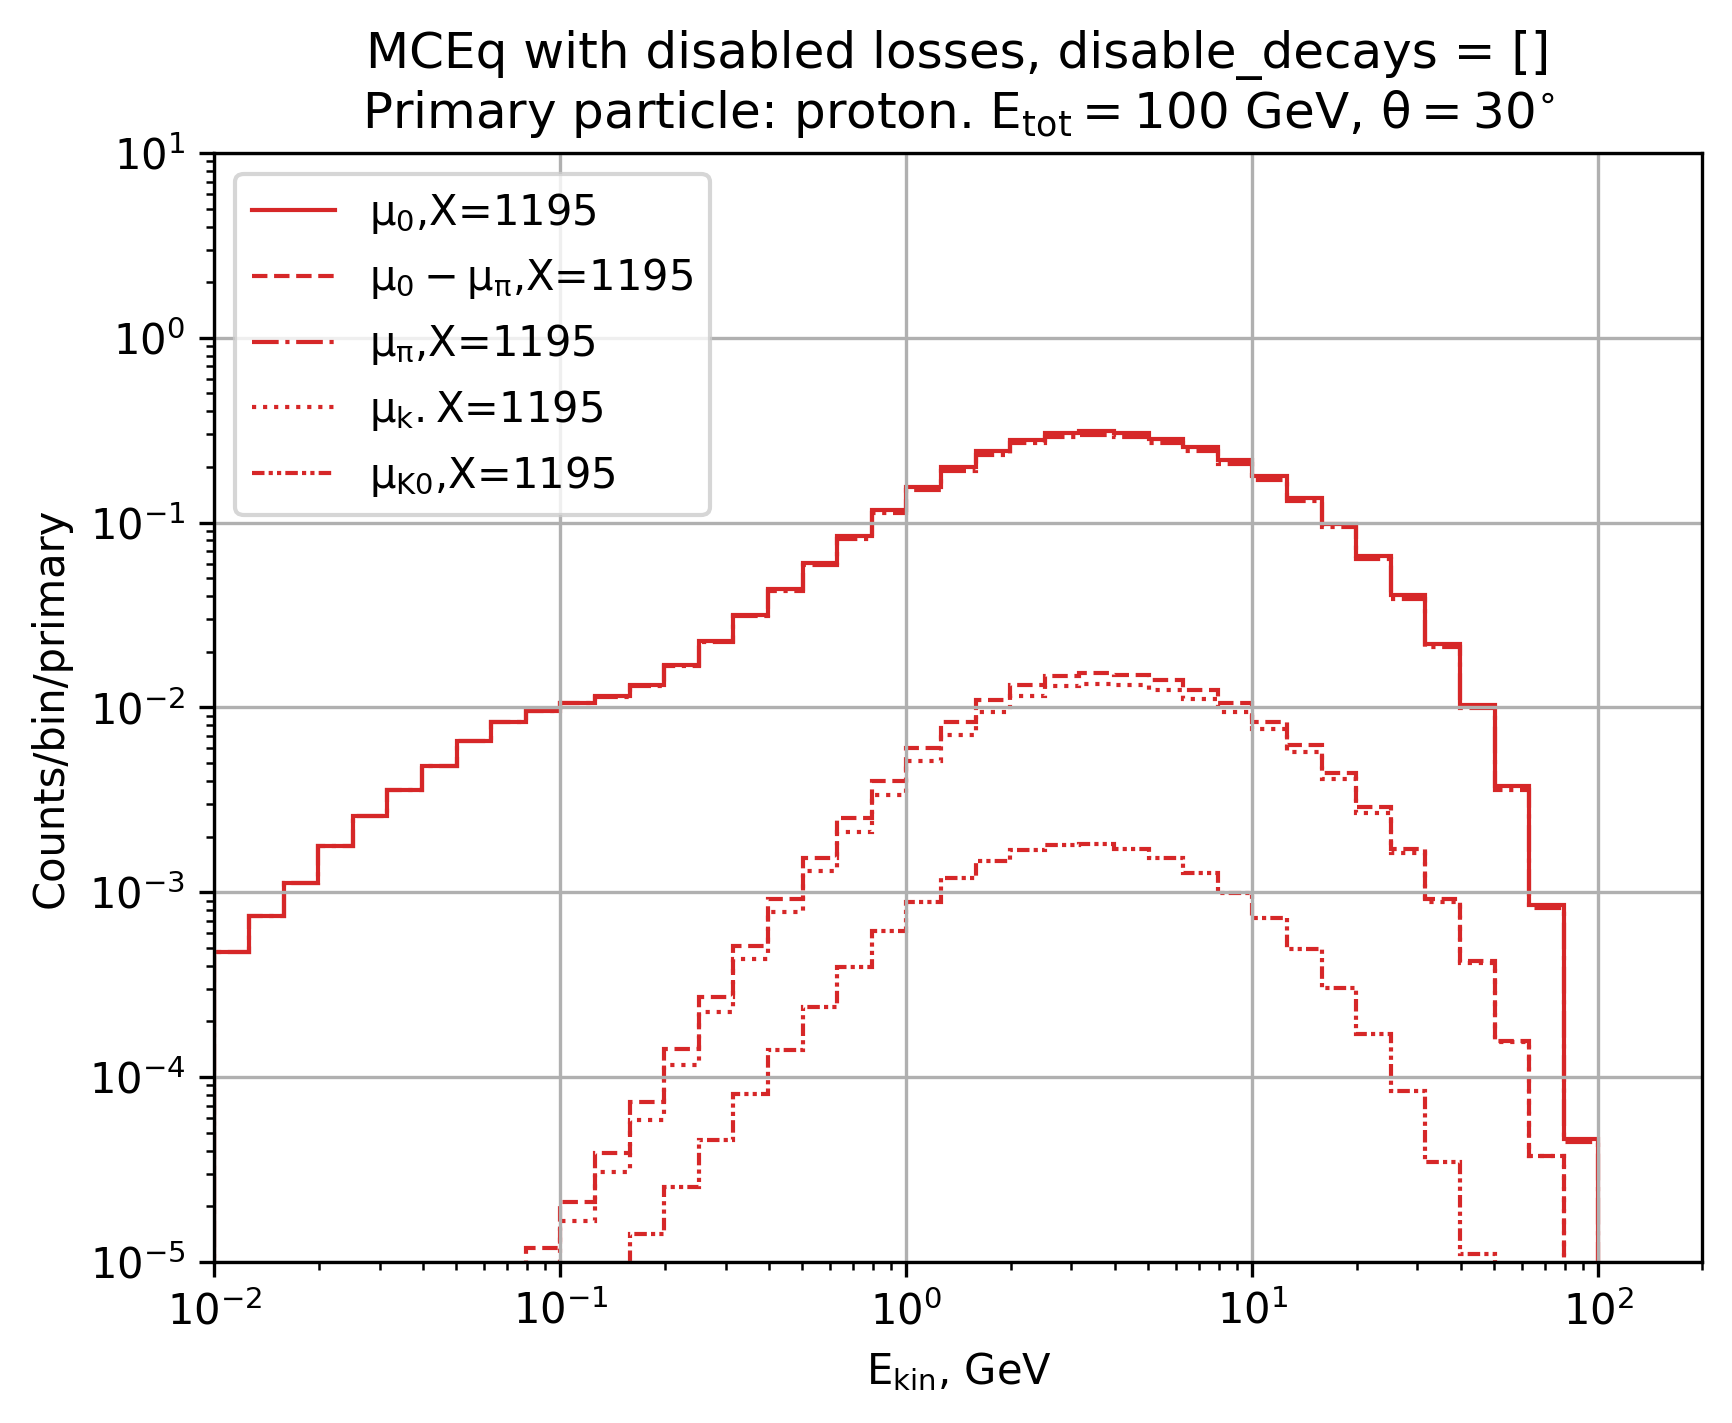

In [225]:
# xdepths_list = [0, 1, 2, 3]
xdepths_list = [3]

for ixdepth in xdepths_list:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"$\mu_0$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='-',
            color = line_colors[ixdepth])    
        
        
    plt.stairs(mceq_dist.flux[ixdepth]["mu"] - mceq_dist.flux[ixdepth]["pi_mu"], mceq_dist.e_bins, 
            label = r"$\mu_0 - \mu_{\pi}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='--',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["pi_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{\pi}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='-.',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["k_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{k}.$" 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle=':',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["K0_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{K0}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle=(0, (3, 1, 1, 1, 1, 1)),
            color = line_colors[ixdepth])
    
#     plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#             label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_loss.slant_depths[ixdepth]}", 
#             linestyle='--',
#             color = line_colors[ixdepth])
    
    # plt.stairs(mceq_loss1.flux[ixdepth]["mu"], mceq_loss1.e_bins, 
    #         label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"loss1={mceq_loss1.slant_depths[ixdepth]}", 
    #         linestyle='--',
    #         color = line_colors[ixdepth])


    # plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

    # plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
    # plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
    #         color = line_colors[2])
    # plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
    #         color = line_colors[1])
    # # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
    #            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
    #            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
    #            label = r"${e}^{+}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
    #            label = r"${e}^{-}$ mceq", linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 2e2)
    plt.ylim(1e-5, 10)
    plt.legend()
    plt.grid()
    plt.title("MCEq with disabled losses, disable_decays = []" + "\nPrimary particle: proton. " 
            +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
    plt.xlabel(r"$E_{kin}$, GeV")
    plt.ylabel(r"Counts/bin/primary")
plt.savefig('16_MCEq_noloss.svg')